In [1]:
import pandas as pd
import numpy as np

In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.2'

In [3]:
exch = 'BTRX'
pair = 'BTC/USDT'

df = pd.read_csv(f"{exch}_{pair.replace('/', '-')}_ohlcv.csv")
df.head()

,timestamp,open,high,low,close,volume
0,2016-12-31 05:02:00,948.000,948.000,942.899,942.899,0.083403
1,2016-12-31 05:03:00,942.899,942.899,942.899,942.899,0.000000
2,2016-12-31 05:04:00,942.899,942.899,942.899,942.899,0.000000
3,2016-12-31 05:05:00,942.899,942.899,942.899,942.899,0.000000
4,2016-12-31 05:06:00,942.899,942.899,942.899,942.899,0.000000


In [4]:
df.dtypes

timestamp     object
open         float64
high         float64
low          float64
close        float64
volume       float64
dtype: object

/home/rlarson/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/rlarson/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


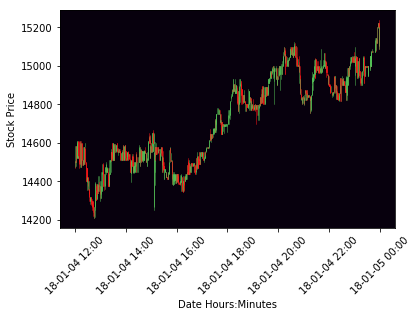

In [5]:
# Plot the stock prices for the last day
import matplotlib.pyplot as plt
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates

plot_last_n_minutes = 60 * 12  # 1/2 day
cs_frame = df.iloc[-1 * plot_last_n_minutes:].copy()  # Create the candlestick frame

#if necessary convert to datetime
cs_frame.timestamp = pd.to_datetime(cs_frame.timestamp)

cs_frame = cs_frame[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
cs_frame["timestamp"] = cs_frame["timestamp"].apply(mdates.date2num)

f1 = plt.subplot2grid((6, 1), (0, 0), rowspan=6, colspan=1, axisbg='#07000d')
candlestick_ohlc(f1, cs_frame.values, width=.0001, colorup='#53c156', colordown='#ff1717', alpha=.75)
f1.xaxis_date()
f1.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))

plt.xticks(rotation=45)
plt.ylabel('Stock Price')
plt.xlabel('Date Hours:Minutes')
plt.show()

# Cleanup memory
%reset_selective -f "^cs_frame$"

In [6]:
# Add a minute moving average over period
def add_moving_avg(df, period=30):
    df[f"{period}_ma"] = pd.rolling_mean(df['close'], period)

In [7]:
add_moving_avg(df)
df.tail()

/home/rlarson/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


,timestamp,open,high,low,close,volume,30_ma
532493,2018-01-04 23:55:00,15199.000000,15200.00000,15199.000000,15199.000000,10.446506,15063.411186
532494,2018-01-04 23:56:00,15199.000000,15220.00000,15195.582639,15220.000000,5.457758,15070.777853
532495,2018-01-04 23:57:00,15220.000000,15238.00000,15200.000000,15201.000000,7.473745,15077.644520
532496,2018-01-04 23:58:00,15200.000000,15202.21529,15085.001000,15101.591266,7.258691,15081.030929
532497,2018-01-04 23:59:00,15101.591266,15199.00000,15085.001000,15199.000000,1.777752,15087.697595


In [8]:
from stock_gym.envs import stocks
import gym

env = gym.make('SinMarketEnv-v0')
#env.add_data(df)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: Could not seed environment <SinMarketEnv instance>


In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, GRU, Dropout
from keras.optimizers import Adam

In [10]:
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [11]:
np.random.seed(123)
env.seed(123)
(env.n_actions, env.observation_space.shape)

WARN: Could not seed environment <SinMarketEnv<SinMarketEnv-v0>>


(3, (1, 128))

In [12]:
model = Sequential()

model.add(GRU(128,
                input_shape=env.observation_space.shape,
                dropout=0.1,
                recurrent_dropout=0.5,
                return_sequences=True,
               #stateful=False,
             ))
model.add(GRU(128,
                dropout=0.1,
                recurrent_dropout=0.5,
                return_sequences=True,
             ))
model.add(GRU(128,
                dropout=0.1,
                recurrent_dropout=0.5,
             ))
#model.add(Dense(64))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))

model.add(Dense(env.n_actions, kernel_initializer='lecun_uniform', activation='linear'))
#model.add(Activation('linear')) #linear output so we can have range of real-valued outputs
#model.add(Dense(env.n_actions, activation='linear'))

# model.add(Flatten(input_shape=env.observation_space.shape))
# model.add(Dense(16))
# model.add(Activation('relu'))
# model.add(Dense(16))
# model.add(Activation('relu'))
# model.add(Dense(16))
# model.add(Activation('relu'))
# model.add(Dense(env.n_actions, activation='linear'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 1, 128)            98688     
_________________________________________________________________
gru_2 (GRU)                  (None, 1, 128)            98688     
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 296,451
Trainable params: 296,451
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
memory = SequentialMemory(limit=env.total_space_size, window_length=1)
policy = BoltzmannQPolicy()

In [14]:
dqn = DQNAgent(model=model, nb_actions=env.n_actions, memory=memory, nb_steps_warmup=100,
               enable_dueling_network=True, dueling_type='avg', target_model_update=1e-2, policy=policy)


In [15]:
#dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.compile(
    #loss='mse',
    optimizer=Adam(lr=1e-3),
    metrics=['mae'],
)

In [16]:
history = dqn.fit(env, nb_steps=5000, visualize=False, verbose=2)

Training for 5000 steps ...
    2/5000: episode: 1, duration: 0.407s, episode steps: 2, steps per second: 5, episode reward: -9999.989, mean reward: -4999.994 [-9999.990, 0.001], mean action: 1.000 [0.000, 2.000], mean observation: 0.959 [0.916, 0.990], loss: --, mean_absolute_error: --, mean_q: --
    3/5000: episode: 2, duration: 0.005s, episode steps: 1, steps per second: 216, episode reward: -999.999, mean reward: -999.999 [-999.999, -999.999], mean action: 1.000 [1.000, 1.000], mean observation: 0.615 [0.519, 0.708], loss: --, mean_absolute_error: --, mean_q: --
    4/5000: episode: 3, duration: 0.004s, episode steps: 1, steps per second: 235, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.748 [0.661, 0.829], loss: --, mean_absolute_error: --, mean_q: --
    5/5000: episode: 4, duration: 0.004s, episode steps: 1, steps per second: 241, episode reward: -999.999, mean reward: -999.999 [-999.999, -999.999], mean action

   47/5000: episode: 46, duration: 0.005s, episode steps: 1, steps per second: 206, episode reward: -999.999, mean reward: -999.999 [-999.999, -999.999], mean action: 1.000 [1.000, 1.000], mean observation: 0.559 [0.462, 0.655], loss: --, mean_absolute_error: --, mean_q: --
   48/5000: episode: 47, duration: 0.005s, episode steps: 1, steps per second: 201, episode reward: -999.999, mean reward: -999.999 [-999.999, -999.999], mean action: 1.000 [1.000, 1.000], mean observation: 0.364 [0.273, 0.459], loss: --, mean_absolute_error: --, mean_q: --
   49/5000: episode: 48, duration: 0.004s, episode steps: 1, steps per second: 271, episode reward: -999.999, mean reward: -999.999 [-999.999, -999.999], mean action: 1.000 [1.000, 1.000], mean observation: 0.421 [0.326, 0.518], loss: --, mean_absolute_error: --, mean_q: --
   50/5000: episode: 49, duration: 0.004s, episode steps: 1, steps per second: 228, episode reward: -999.999, mean reward: -999.999 [-999.999, -999.999], mean action: 1.000 [1

  101/5000: episode: 100, duration: 4.889s, episode steps: 1, steps per second: 0, episode reward: -999.999, mean reward: -999.999 [-999.999, -999.999], mean action: 1.000 [1.000, 1.000], mean observation: 0.079 [0.033, 0.136], loss: --, mean_absolute_error: --, mean_q: --
  102/5000: episode: 101, duration: 0.036s, episode steps: 1, steps per second: 28, episode reward: -999.999, mean reward: -999.999 [-999.999, -999.999], mean action: 1.000 [1.000, 1.000], mean observation: 0.096 [0.045, 0.157], loss: 6452992.000000, mean_absolute_error: 552.357178, mean_q: -0.063400
  103/5000: episode: 102, duration: 0.037s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.011 [0.000, 0.035], loss: 8061973.500000, mean_absolute_error: 688.050537, mean_q: -0.240484
  104/5000: episode: 103, duration: 0.037s, episode steps: 1, steps per second: 27, episode reward: 0.022, mean reward: 0.022 [0.022, 

  132/5000: episode: 131, duration: 0.047s, episode steps: 1, steps per second: 21, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.994 [0.977, 1.000], loss: 6396399.500000, mean_absolute_error: 553.199341, mean_q: -9.924541
  133/5000: episode: 132, duration: 0.125s, episode steps: 1, steps per second: 8, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.146 [0.083, 0.219], loss: 4929961.000000, mean_absolute_error: 510.273621, mean_q: -10.502493
  134/5000: episode: 133, duration: 0.091s, episode steps: 1, steps per second: 11, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.018 [0.001, 0.048], loss: 6408213.000000, mean_absolute_error: 563.963257, mean_q: -10.273220
  135/5000: episode: 134, duration: 0.076s, episode steps: 1, steps per second: 13, episode reward: 0.001, mean reward: 0.001 [0.

  161/5000: episode: 160, duration: 0.040s, episode steps: 1, steps per second: 25, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.959 [0.916, 0.990], loss: 4778166.500000, mean_absolute_error: 426.744080, mean_q: -11.061828
  162/5000: episode: 161, duration: 0.094s, episode steps: 1, steps per second: 11, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.974 [0.939, 0.997], loss: 4865445.000000, mean_absolute_error: 485.460297, mean_q: -11.111400
  163/5000: episode: 162, duration: 0.035s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.258 [0.176, 0.345], loss: 161321.796875, mean_absolute_error: 136.880920, mean_q: -11.148272
  164/5000: episode: 163, duration: 0.035s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0

  195/5000: episode: 194, duration: 0.034s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.993 [0.975, 1.000], loss: 1630121.625000, mean_absolute_error: 198.070374, mean_q: -12.239726
  196/5000: episode: 195, duration: 0.066s, episode steps: 1, steps per second: 15, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.079 [0.033, 0.136], loss: 3245520.250000, mean_absolute_error: 349.473938, mean_q: -12.267780
  197/5000: episode: 196, duration: 0.106s, episode steps: 1, steps per second: 9, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.449 [0.353, 0.546], loss: 4730489.500000, mean_absolute_error: 414.111664, mean_q: -12.280773
  198/5000: episode: 197, duration: 0.039s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0

  224/5000: episode: 223, duration: 0.048s, episode steps: 1, steps per second: 21, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.907 [0.846, 0.957], loss: 129052.648438, mean_absolute_error: 128.897522, mean_q: -12.873022
  225/5000: episode: 224, duration: 0.041s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.176 [0.107, 0.254], loss: 1683066.125000, mean_absolute_error: 241.408463, mean_q: -12.894258
  226/5000: episode: 225, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.840 [0.765, 0.906], loss: 4761259.500000, mean_absolute_error: 446.575256, mean_q: -12.919408
  227/5000: episode: 226, duration: 0.032s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0

  253/5000: episode: 252, duration: 0.145s, episode steps: 1, steps per second: 7, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.005 [0.000, 0.019], loss: 4722835.500000, mean_absolute_error: 431.152222, mean_q: -13.281654
  254/5000: episode: 253, duration: 0.117s, episode steps: 1, steps per second: 9, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.132 [0.072, 0.202], loss: 141890.546875, mean_absolute_error: 142.911255, mean_q: -13.332699
  255/5000: episode: 254, duration: 0.152s, episode steps: 1, steps per second: 7, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.968 [0.930, 0.995], loss: 1621277.000000, mean_absolute_error: 207.800690, mean_q: -13.372960
  256/5000: episode: 255, duration: 0.133s, episode steps: 1, steps per second: 7, episode reward: 0.001, mean reward: 0.001 [0.001

  283/5000: episode: 282, duration: 0.141s, episode steps: 1, steps per second: 7, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.861 [0.789, 0.923], loss: 3164717.000000, mean_absolute_error: 323.358887, mean_q: -13.802805
  284/5000: episode: 283, duration: 0.121s, episode steps: 1, steps per second: 8, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.233 [0.155, 0.318], loss: 3122598.000000, mean_absolute_error: 295.711639, mean_q: -13.820202
  285/5000: episode: 284, duration: 0.130s, episode steps: 1, steps per second: 8, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.760 [0.674, 0.839], loss: 70597.828125, mean_absolute_error: 100.705910, mean_q: -13.836855
  286/5000: episode: 285, duration: 0.163s, episode steps: 1, steps per second: 6, episode reward: 0.001, mean reward: 0.001 [0.001,

  312/5000: episode: 311, duration: 0.075s, episode steps: 1, steps per second: 13, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.456 [0.360, 0.553], loss: 1586056.500000, mean_absolute_error: 197.052750, mean_q: -14.144098
  313/5000: episode: 312, duration: 0.054s, episode steps: 1, steps per second: 19, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.091 [0.041, 0.151], loss: 1572585.375000, mean_absolute_error: 188.131805, mean_q: -14.169995
  314/5000: episode: 313, duration: 0.064s, episode steps: 1, steps per second: 16, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.709 [0.619, 0.794], loss: 1586006.500000, mean_absolute_error: 197.410217, mean_q: -14.191534
  315/5000: episode: 314, duration: 0.041s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [

  342/5000: episode: 341, duration: 0.068s, episode steps: 1, steps per second: 15, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.137 [0.075, 0.207], loss: 3096131.500000, mean_absolute_error: 293.967407, mean_q: -14.651155
  343/5000: episode: 342, duration: 0.037s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.024 [0.002, 0.057], loss: 3123676.250000, mean_absolute_error: 312.385376, mean_q: -14.665894
  344/5000: episode: 343, duration: 0.030s, episode steps: 1, steps per second: 34, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.003 [0.000, 0.011], loss: 1596537.250000, mean_absolute_error: 210.802490, mean_q: -14.682914
  345/5000: episode: 344, duration: 0.030s, episode steps: 1, steps per second: 34, episode reward: 0.001, mean reward: 0.001 [

  373/5000: episode: 372, duration: 0.042s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.916 [0.858, 0.964], loss: 1566332.375000, mean_absolute_error: 195.833374, mean_q: -14.705189
  374/5000: episode: 373, duration: 0.059s, episode steps: 1, steps per second: 17, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.018 [0.001, 0.047], loss: 55134.398438, mean_absolute_error: 103.323586, mean_q: -14.715356
  375/5000: episode: 374, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.842 [0.767, 0.908], loss: 3091482.250000, mean_absolute_error: 297.781006, mean_q: -14.724226
  376/5000: episode: 375, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.

  402/5000: episode: 401, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.018 [0.001, 0.047], loss: 1603969.375000, mean_absolute_error: 226.158920, mean_q: -14.978363
  403/5000: episode: 402, duration: 0.080s, episode steps: 1, steps per second: 12, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.803 [0.723, 0.876], loss: 1603853.875000, mean_absolute_error: 226.288330, mean_q: -14.998947
  404/5000: episode: 403, duration: 0.043s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.156 [0.090, 0.230], loss: 3099377.750000, mean_absolute_error: 309.995392, mean_q: -15.014854
  405/5000: episode: 404, duration: 0.039s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [

  436/5000: episode: 435, duration: 0.030s, episode steps: 1, steps per second: 33, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.460 [0.364, 0.557], loss: 3080448.500000, mean_absolute_error: 304.622314, mean_q: -15.194572
  437/5000: episode: 436, duration: 0.075s, episode steps: 1, steps per second: 13, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.611 [0.515, 0.704], loss: 67453.078125, mean_absolute_error: 119.820221, mean_q: -15.197148
  438/5000: episode: 437, duration: 0.039s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.496 [0.399, 0.593], loss: 4573439.500000, mean_absolute_error: 388.416504, mean_q: -15.193417
  439/5000: episode: 438, duration: 0.070s, episode steps: 1, steps per second: 14, episode reward: 0.001, mean reward: 0.001 [0.

  465/5000: episode: 464, duration: 0.050s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.301 [0.215, 0.393], loss: 40404.359375, mean_absolute_error: 105.497269, mean_q: -15.327045
  466/5000: episode: 465, duration: 0.054s, episode steps: 1, steps per second: 19, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.967 [0.928, 0.994], loss: 3088886.750000, mean_absolute_error: 316.681702, mean_q: -15.326324
  467/5000: episode: 466, duration: 0.054s, episode steps: 1, steps per second: 19, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.237 [0.158, 0.322], loss: 1571167.750000, mean_absolute_error: 215.558945, mean_q: -15.330346
  468/5000: episode: 467, duration: 0.033s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.

  498/5000: episode: 497, duration: 0.048s, episode steps: 1, steps per second: 21, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.986 [0.960, 1.000], loss: 1541965.625000, mean_absolute_error: 201.128815, mean_q: -15.327841
  499/5000: episode: 498, duration: 0.095s, episode steps: 1, steps per second: 10, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.713 [0.623, 0.798], loss: 1581861.375000, mean_absolute_error: 227.482773, mean_q: -15.327514
  500/5000: episode: 499, duration: 0.038s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.136 [0.075, 0.207], loss: 92420.539062, mean_absolute_error: 143.953491, mean_q: -15.334781
  501/5000: episode: 500, duration: 0.038s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.

  528/5000: episode: 527, duration: 0.084s, episode steps: 1, steps per second: 12, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.907 [0.847, 0.958], loss: 1552955.000000, mean_absolute_error: 213.155426, mean_q: -15.602951
  529/5000: episode: 528, duration: 0.048s, episode steps: 1, steps per second: 21, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.154 [0.089, 0.228], loss: 52981.195312, mean_absolute_error: 121.170685, mean_q: -15.614174
  530/5000: episode: 529, duration: 0.037s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.573 [0.476, 0.668], loss: 79187.734375, mean_absolute_error: 138.636353, mean_q: -15.624062
  531/5000: episode: 530, duration: 0.033s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.00

  559/5000: episode: 558, duration: 0.054s, episode steps: 1, steps per second: 19, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.616 [0.521, 0.709], loss: 13606.863281, mean_absolute_error: 98.402634, mean_q: -15.688999
  560/5000: episode: 559, duration: 0.067s, episode steps: 1, steps per second: 15, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.883 [0.816, 0.940], loss: 65632.906250, mean_absolute_error: 132.831421, mean_q: -15.690887
  561/5000: episode: 560, duration: 0.057s, episode steps: 1, steps per second: 17, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.827 [0.750, 0.896], loss: 65180.882812, mean_absolute_error: 132.896439, mean_q: -15.687454
  562/5000: episode: 561, duration: 0.041s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001, 

  588/5000: episode: 587, duration: 0.073s, episode steps: 1, steps per second: 14, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.984 [0.956, 1.000], loss: 1573864.750000, mean_absolute_error: 236.014923, mean_q: -15.636710
  589/5000: episode: 588, duration: 0.061s, episode steps: 1, steps per second: 16, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.914 [0.856, 0.962], loss: 26477.523438, mean_absolute_error: 110.044678, mean_q: -15.633554
  590/5000: episode: 589, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.784 [0.701, 0.860], loss: 1561819.875000, mean_absolute_error: 227.865768, mean_q: -15.625784
  591/5000: episode: 590, duration: 0.032s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.

  620/5000: episode: 619, duration: 0.034s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.654 [0.560, 0.744], loss: 12959.960938, mean_absolute_error: 105.170212, mean_q: -15.904016
  621/5000: episode: 620, duration: 0.054s, episode steps: 1, steps per second: 18, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.144 [0.081, 0.217], loss: 39747.242188, mean_absolute_error: 122.432076, mean_q: -15.918148
  622/5000: episode: 621, duration: 0.033s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.160 [0.094, 0.235], loss: 1519352.750000, mean_absolute_error: 205.796051, mean_q: -15.920113
  623/5000: episode: 622, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.00

  649/5000: episode: 648, duration: 0.120s, episode steps: 1, steps per second: 8, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.011 [0.000, 0.034], loss: 25648.962891, mean_absolute_error: 116.790359, mean_q: -16.080334
  650/5000: episode: 649, duration: 0.047s, episode steps: 1, steps per second: 21, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.019 [0.001, 0.050], loss: 39007.546875, mean_absolute_error: 125.436111, mean_q: -16.098686
  651/5000: episode: 650, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.717 [0.627, 0.801], loss: 3021339.250000, mean_absolute_error: 309.124084, mean_q: -16.108555
  652/5000: episode: 651, duration: 0.032s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001

  681/5000: episode: 680, duration: 0.039s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.068 [0.026, 0.121], loss: 1540186.625000, mean_absolute_error: 229.624466, mean_q: -16.633669
  682/5000: episode: 681, duration: 0.051s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.055 [0.018, 0.104], loss: 38785.980469, mean_absolute_error: 129.584473, mean_q: -16.637621
  683/5000: episode: 682, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.972 [0.936, 0.996], loss: 3015185.750000, mean_absolute_error: 313.060303, mean_q: -16.638210
  684/5000: episode: 683, duration: 0.034s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.

  713/5000: episode: 712, duration: 0.035s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.018 [0.001, 0.047], loss: 12742.390625, mean_absolute_error: 116.254974, mean_q: -16.777916
  714/5000: episode: 713, duration: 0.069s, episode steps: 1, steps per second: 15, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.211 [0.136, 0.293], loss: 1524295.500000, mean_absolute_error: 224.494995, mean_q: -16.761766
  715/5000: episode: 714, duration: 0.050s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.912 [0.853, 0.961], loss: 64537.828125, mean_absolute_error: 149.722412, mean_q: -16.756096
  716/5000: episode: 715, duration: 0.048s, episode steps: 1, steps per second: 21, episode reward: 0.001, mean reward: 0.001 [0.00

  744/5000: episode: 743, duration: 0.043s, episode steps: 1, steps per second: 23, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.246 [0.166, 0.332], loss: 39117.906250, mean_absolute_error: 135.597900, mean_q: -16.648987
  745/5000: episode: 744, duration: 0.084s, episode steps: 1, steps per second: 12, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.299 [0.213, 0.390], loss: 12656.491211, mean_absolute_error: 119.170876, mean_q: -16.643293
  746/5000: episode: 745, duration: 0.035s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.058 [0.020, 0.108], loss: 26692.238281, mean_absolute_error: 127.689590, mean_q: -16.634514
  747/5000: episode: 746, duration: 0.033s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001,

  777/5000: episode: 776, duration: 0.062s, episode steps: 1, steps per second: 16, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.389 [0.296, 0.485], loss: 38980.101562, mean_absolute_error: 138.176971, mean_q: -16.401274
  778/5000: episode: 777, duration: 0.090s, episode steps: 1, steps per second: 11, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.503 [0.406, 0.600], loss: 1508035.875000, mean_absolute_error: 221.451462, mean_q: -16.393200
  779/5000: episode: 778, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.234 [0.156, 0.319], loss: 3003370.250000, mean_absolute_error: 321.191467, mean_q: -16.394804
  780/5000: episode: 779, duration: 0.034s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.

  810/5000: episode: 809, duration: 0.069s, episode steps: 1, steps per second: 14, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.639 [0.545, 0.731], loss: 37170.265625, mean_absolute_error: 140.877075, mean_q: -16.164967
  811/5000: episode: 810, duration: 0.091s, episode steps: 1, steps per second: 11, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.402 [0.309, 0.498], loss: 1530803.375000, mean_absolute_error: 240.499390, mean_q: -16.164806
  812/5000: episode: 811, duration: 0.039s, episode steps: 1, steps per second: 25, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.810 [0.731, 0.882], loss: 37979.093750, mean_absolute_error: 141.159775, mean_q: -16.168396
  813/5000: episode: 812, duration: 0.033s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.00

  842/5000: episode: 841, duration: 0.043s, episode steps: 1, steps per second: 23, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.861 [0.790, 0.923], loss: 3011269.000000, mean_absolute_error: 334.023193, mean_q: -15.642364
  843/5000: episode: 842, duration: 0.079s, episode steps: 1, steps per second: 13, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.567 [0.470, 0.662], loss: 1505629.000000, mean_absolute_error: 226.544495, mean_q: -15.638052
  844/5000: episode: 843, duration: 0.041s, episode steps: 1, steps per second: 25, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.123 [0.065, 0.190], loss: 1492468.875000, mean_absolute_error: 218.524689, mean_q: -15.633444
  845/5000: episode: 844, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [

  871/5000: episode: 870, duration: 0.084s, episode steps: 1, steps per second: 12, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.979 [0.947, 0.999], loss: 37564.519531, mean_absolute_error: 145.507355, mean_q: -15.479587
  872/5000: episode: 871, duration: 0.055s, episode steps: 1, steps per second: 18, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.360 [0.269, 0.454], loss: 12295.750977, mean_absolute_error: 129.566132, mean_q: -15.487530
  873/5000: episode: 872, duration: 0.030s, episode steps: 1, steps per second: 33, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.719 [0.629, 0.803], loss: 1528257.875000, mean_absolute_error: 245.059952, mean_q: -15.490598
  874/5000: episode: 873, duration: 0.030s, episode steps: 1, steps per second: 33, episode reward: 0.001, mean reward: 0.001 [0.00

  901/5000: episode: 900, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.975 [0.940, 0.997], loss: 13167.080078, mean_absolute_error: 132.242477, mean_q: -15.298957
  902/5000: episode: 901, duration: 0.115s, episode steps: 1, steps per second: 9, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.789 [0.707, 0.864], loss: 1489258.750000, mean_absolute_error: 223.507065, mean_q: -15.282608
  903/5000: episode: 902, duration: 0.045s, episode steps: 1, steps per second: 22, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.997 [0.990, 1.000], loss: 25194.578125, mean_absolute_error: 140.219177, mean_q: -15.274382
  904/5000: episode: 903, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001

  935/5000: episode: 934, duration: 0.045s, episode steps: 1, steps per second: 22, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.753 [0.667, 0.833], loss: 110.841827, mean_absolute_error: 126.920059, mean_q: -14.888044
  936/5000: episode: 935, duration: 0.069s, episode steps: 1, steps per second: 15, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.979 [0.947, 0.999], loss: 36114.570312, mean_absolute_error: 150.525803, mean_q: -14.877190
  937/5000: episode: 936, duration: 0.032s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.206 [0.131, 0.287], loss: 48104.082031, mean_absolute_error: 158.446747, mean_q: -14.866552
  938/5000: episode: 937, duration: 0.036s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0

  966/5000: episode: 965, duration: 0.049s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.960 [0.918, 0.991], loss: 13004.509766, mean_absolute_error: 137.906616, mean_q: -14.890355
  967/5000: episode: 966, duration: 0.086s, episode steps: 1, steps per second: 12, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.878 [0.810, 0.936], loss: 14107.073242, mean_absolute_error: 138.164520, mean_q: -14.883096
  968/5000: episode: 967, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.797 [0.715, 0.871], loss: 1497508.375000, mean_absolute_error: 237.023529, mean_q: -14.869637
  969/5000: episode: 968, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.00

  997/5000: episode: 996, duration: 0.066s, episode steps: 1, steps per second: 15, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.471 [0.375, 0.568], loss: 1508750.625000, mean_absolute_error: 247.097153, mean_q: -14.705167
  998/5000: episode: 997, duration: 0.082s, episode steps: 1, steps per second: 12, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.995 [0.979, 1.000], loss: 1520557.250000, mean_absolute_error: 254.956848, mean_q: -14.702619
  999/5000: episode: 998, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.003 [0.000, 0.013], loss: 2979487.250000, mean_absolute_error: 338.398071, mean_q: -14.704319
 1000/5000: episode: 999, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [

 1027/5000: episode: 1026, duration: 0.038s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.624 [0.529, 0.716], loss: 13023.083008, mean_absolute_error: 144.004791, mean_q: -14.974296
 1028/5000: episode: 1027, duration: 0.051s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.292 [0.207, 0.382], loss: 11903.921875, mean_absolute_error: 144.071381, mean_q: -14.990475
 1029/5000: episode: 1028, duration: 0.104s, episode steps: 1, steps per second: 10, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.881 [0.814, 0.938], loss: 11902.565430, mean_absolute_error: 144.170654, mean_q: -14.996893
 1030/5000: episode: 1029, duration: 0.037s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.

 1056/5000: episode: 1055, duration: 0.065s, episode steps: 1, steps per second: 15, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.119 [0.062, 0.186], loss: 23562.191406, mean_absolute_error: 153.369049, mean_q: -14.526632
 1057/5000: episode: 1056, duration: 0.047s, episode steps: 1, steps per second: 21, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.870 [0.801, 0.930], loss: 23558.734375, mean_absolute_error: 153.417450, mean_q: -14.506863
 1058/5000: episode: 1057, duration: 0.072s, episode steps: 1, steps per second: 14, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.811 [0.731, 0.882], loss: 12959.203125, mean_absolute_error: 145.854324, mean_q: -14.483339
 1059/5000: episode: 1058, duration: 0.099s, episode steps: 1, steps per second: 10, episode reward: 0.001, mean reward: 0.001 [0.

 1087/5000: episode: 1086, duration: 0.066s, episode steps: 1, steps per second: 15, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.751 [0.664, 0.831], loss: 1516276.750000, mean_absolute_error: 261.789581, mean_q: -14.195307
 1088/5000: episode: 1087, duration: 0.036s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.948 [0.900, 0.984], loss: 1504551.250000, mean_absolute_error: 254.307404, mean_q: -14.193132
 1089/5000: episode: 1088, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.277 [0.194, 0.367], loss: 1504474.875000, mean_absolute_error: 254.410782, mean_q: -14.196223
 1090/5000: episode: 1089, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.0

 1119/5000: episode: 1118, duration: 0.057s, episode steps: 1, steps per second: 18, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.005 [0.000, 0.020], loss: 102.921585, mean_absolute_error: 144.422424, mean_q: -14.346235
 1120/5000: episode: 1119, duration: 0.035s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.003 [0.000, 0.013], loss: 15536.967773, mean_absolute_error: 152.269272, mean_q: -14.336012
 1121/5000: episode: 1120, duration: 0.034s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.902 [0.840, 0.954], loss: 2975856.500000, mean_absolute_error: 356.267090, mean_q: -14.320179
 1122/5000: episode: 1121, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.

 1150/5000: episode: 1149, duration: 0.055s, episode steps: 1, steps per second: 18, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.417 [0.323, 0.514], loss: 23097.738281, mean_absolute_error: 161.841431, mean_q: -14.104357
 1151/5000: episode: 1150, duration: 0.036s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.122 [0.064, 0.190], loss: 1486376.375000, mean_absolute_error: 252.655350, mean_q: -14.080120
 1152/5000: episode: 1151, duration: 0.035s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.969 [0.932, 0.995], loss: 2962410.000000, mean_absolute_error: 351.017883, mean_q: -14.063587
 1153/5000: episode: 1152, duration: 0.038s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001

 1180/5000: episode: 1179, duration: 0.087s, episode steps: 1, steps per second: 12, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.631 [0.536, 0.723], loss: 11519.489258, mean_absolute_error: 156.850586, mean_q: -13.821115
 1181/5000: episode: 1180, duration: 0.058s, episode steps: 1, steps per second: 17, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.082 [0.035, 0.139], loss: 11517.270508, mean_absolute_error: 156.925323, mean_q: -13.812025
 1182/5000: episode: 1181, duration: 0.074s, episode steps: 1, steps per second: 14, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.896 [0.833, 0.950], loss: 1499.282471, mean_absolute_error: 149.716782, mean_q: -13.807970
 1183/5000: episode: 1182, duration: 0.068s, episode steps: 1, steps per second: 15, episode reward: 0.001, mean reward: 0.001 [0.0

 1209/5000: episode: 1208, duration: 0.048s, episode steps: 1, steps per second: 21, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.007 [0.000, 0.025], loss: 45581.250000, mean_absolute_error: 181.313751, mean_q: -13.707689
 1210/5000: episode: 1209, duration: 0.120s, episode steps: 1, steps per second: 8, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.476 [0.379, 0.573], loss: 93.564316, mean_absolute_error: 151.920624, mean_q: -13.678495
 1211/5000: episode: 1210, duration: 0.049s, episode steps: 1, steps per second: 21, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.996 [0.984, 1.000], loss: 22827.421875, mean_absolute_error: 166.659622, mean_q: -13.647507
 1212/5000: episode: 1211, duration: 0.071s, episode steps: 1, steps per second: 14, episode reward: 0.001, mean reward: 0.001 [0.001,

 1240/5000: episode: 1239, duration: 0.096s, episode steps: 1, steps per second: 10, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.378 [0.285, 0.473], loss: 11394.573242, mean_absolute_error: 161.832230, mean_q: -13.503844
 1241/5000: episode: 1240, duration: 0.085s, episode steps: 1, steps per second: 12, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.446 [0.350, 0.542], loss: 90.809479, mean_absolute_error: 154.556137, mean_q: -13.475608
 1242/5000: episode: 1241, duration: 0.091s, episode steps: 1, steps per second: 11, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.941 [0.891, 0.980], loss: 1498412.875000, mean_absolute_error: 267.309601, mean_q: -13.455441
 1243/5000: episode: 1242, duration: 0.090s, episode steps: 1, steps per second: 11, episode reward: 0.001, mean reward: 0.001 [0.0

 1270/5000: episode: 1269, duration: 0.058s, episode steps: 1, steps per second: 17, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.102 [0.049, 0.165], loss: 84.514816, mean_absolute_error: 156.505737, mean_q: -13.000139
 1271/5000: episode: 1270, duration: 0.060s, episode steps: 1, steps per second: 17, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.006 [0.000, 0.023], loss: 24006.103516, mean_absolute_error: 171.117432, mean_q: -13.005697
 1272/5000: episode: 1271, duration: 0.039s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.833 [0.757, 0.900], loss: 1543.058960, mean_absolute_error: 156.712463, mean_q: -13.006987
 1273/5000: episode: 1272, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001,

 1302/5000: episode: 1301, duration: 0.052s, episode steps: 1, steps per second: 19, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.076 [0.031, 0.132], loss: 78.418083, mean_absolute_error: 158.506012, mean_q: -12.522425
 1303/5000: episode: 1302, duration: 0.101s, episode steps: 1, steps per second: 10, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.224 [0.147, 0.308], loss: 14283.765625, mean_absolute_error: 165.843521, mean_q: -12.514769
 1304/5000: episode: 1303, duration: 0.060s, episode steps: 1, steps per second: 17, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.288 [0.203, 0.378], loss: 33558.074219, mean_absolute_error: 180.225067, mean_q: -12.506697
 1305/5000: episode: 1304, duration: 0.038s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001

 1333/5000: episode: 1332, duration: 0.044s, episode steps: 1, steps per second: 23, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.014 [0.000, 0.040], loss: 1478388.625000, mean_absolute_error: 266.301392, mean_q: -12.515247
 1334/5000: episode: 1333, duration: 0.097s, episode steps: 1, steps per second: 10, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.097 [0.045, 0.158], loss: 22266.818359, mean_absolute_error: 175.890091, mean_q: -12.502056
 1335/5000: episode: 1334, duration: 0.096s, episode steps: 1, steps per second: 10, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.309 [0.222, 0.400], loss: 1487801.875000, mean_absolute_error: 273.574951, mean_q: -12.488514
 1336/5000: episode: 1335, duration: 0.103s, episode steps: 1, steps per second: 10, episode reward: 0.001, mean reward: 0.001

 1366/5000: episode: 1365, duration: 0.070s, episode steps: 1, steps per second: 14, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.005 [0.000, 0.020], loss: 23721.486328, mean_absolute_error: 178.040253, mean_q: -11.940090
 1367/5000: episode: 1366, duration: 0.078s, episode steps: 1, steps per second: 13, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.940 [0.889, 0.979], loss: 11073.929688, mean_absolute_error: 170.982376, mean_q: -11.924109
 1368/5000: episode: 1367, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.412 [0.318, 0.509], loss: 22071.773438, mean_absolute_error: 178.117325, mean_q: -11.909832
 1369/5000: episode: 1368, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.

 1399/5000: episode: 1398, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.597 [0.501, 0.691], loss: 1473645.375000, mean_absolute_error: 270.986755, mean_q: -11.778344
 1400/5000: episode: 1399, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.851 [0.779, 0.915], loss: 69.312981, mean_absolute_error: 166.661011, mean_q: -11.772952
 1401/5000: episode: 1400, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.995 [0.982, 1.000], loss: 12739.904297, mean_absolute_error: 173.857941, mean_q: -11.773588
 1402/5000: episode: 1401, duration: 0.037s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.0

 1429/5000: episode: 1428, duration: 0.057s, episode steps: 1, steps per second: 17, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.616 [0.520, 0.708], loss: 36250.539062, mean_absolute_error: 190.176239, mean_q: -11.588581
 1430/5000: episode: 1429, duration: 0.045s, episode steps: 1, steps per second: 22, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.011 [0.000, 0.034], loss: 2922085.500000, mean_absolute_error: 363.753510, mean_q: -11.568130
 1431/5000: episode: 1430, duration: 0.036s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.085 [0.037, 0.143], loss: 1870.389282, mean_absolute_error: 169.365692, mean_q: -11.565767
 1432/5000: episode: 1431, duration: 0.037s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0

 1461/5000: episode: 1460, duration: 0.093s, episode steps: 1, steps per second: 11, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.476 [0.380, 0.573], loss: 1840.272705, mean_absolute_error: 172.020782, mean_q: -11.526037
 1462/5000: episode: 1461, duration: 0.057s, episode steps: 1, steps per second: 18, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.955 [0.910, 0.988], loss: 66.317078, mean_absolute_error: 172.078156, mean_q: -11.515690
 1463/5000: episode: 1462, duration: 0.036s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.717 [0.628, 0.802], loss: 10874.165039, mean_absolute_error: 179.059372, mean_q: -11.505875
 1464/5000: episode: 1463, duration: 0.033s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001,

 1493/5000: episode: 1492, duration: 0.085s, episode steps: 1, steps per second: 12, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.432 [0.337, 0.529], loss: 10799.154297, mean_absolute_error: 181.990326, mean_q: -11.436642
 1494/5000: episode: 1493, duration: 0.048s, episode steps: 1, steps per second: 21, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.020 [0.001, 0.051], loss: 10796.175781, mean_absolute_error: 182.053375, mean_q: -11.416354
 1495/5000: episode: 1494, duration: 0.037s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.650 [0.556, 0.740], loss: 23467.839844, mean_absolute_error: 189.055710, mean_q: -11.393103
 1496/5000: episode: 1495, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.

 1522/5000: episode: 1521, duration: 0.055s, episode steps: 1, steps per second: 18, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.247 [0.167, 0.334], loss: 64.022636, mean_absolute_error: 177.691635, mean_q: -11.314709
 1523/5000: episode: 1522, duration: 0.064s, episode steps: 1, steps per second: 16, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.039 [0.009, 0.081], loss: 63.876240, mean_absolute_error: 177.764069, mean_q: -11.301764
 1524/5000: episode: 1523, duration: 0.035s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.004 [0.000, 0.016], loss: 12647.168945, mean_absolute_error: 184.640244, mean_q: -11.284468
 1525/5000: episode: 1524, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0

 1552/5000: episode: 1551, duration: 0.066s, episode steps: 1, steps per second: 15, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.039 [0.009, 0.081], loss: 61.849152, mean_absolute_error: 180.067230, mean_q: -11.120974
 1553/5000: episode: 1552, duration: 0.058s, episode steps: 1, steps per second: 17, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.007 [0.000, 0.026], loss: 4075.879883, mean_absolute_error: 180.250824, mean_q: -11.113628
 1554/5000: episode: 1553, duration: 0.036s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.746 [0.659, 0.827], loss: 2939708.500000, mean_absolute_error: 394.077637, mean_q: -11.106354
 1555/5000: episode: 1554, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.00

 1584/5000: episode: 1583, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.996 [0.984, 1.000], loss: 62.477947, mean_absolute_error: 183.387970, mean_q: -11.177366
 1585/5000: episode: 1584, duration: 0.076s, episode steps: 1, steps per second: 13, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.495 [0.399, 0.592], loss: 62.305244, mean_absolute_error: 183.468445, mean_q: -11.161907
 1586/5000: episode: 1585, duration: 0.040s, episode steps: 1, steps per second: 25, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.882 [0.816, 0.939], loss: 31683.228516, mean_absolute_error: 203.623169, mean_q: -11.143322
 1587/5000: episode: 1586, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0

 1614/5000: episode: 1613, duration: 0.064s, episode steps: 1, steps per second: 16, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.927 [0.873, 0.971], loss: 12624.080078, mean_absolute_error: 192.396820, mean_q: -10.894911
 1615/5000: episode: 1614, duration: 0.075s, episode steps: 1, steps per second: 13, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.316 [0.228, 0.408], loss: 10536.927734, mean_absolute_error: 192.484894, mean_q: -10.888063
 1616/5000: episode: 1615, duration: 0.035s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.036 [0.007, 0.076], loss: 10534.476562, mean_absolute_error: 192.597916, mean_q: -10.893282
 1617/5000: episode: 1616, duration: 0.035s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.

 1646/5000: episode: 1645, duration: 0.086s, episode steps: 1, steps per second: 12, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.738 [0.650, 0.820], loss: 1451152.250000, mean_absolute_error: 284.749939, mean_q: -10.594120
 1647/5000: episode: 1646, duration: 0.064s, episode steps: 1, steps per second: 16, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.382 [0.289, 0.477], loss: 55.989971, mean_absolute_error: 188.298325, mean_q: -10.581057
 1648/5000: episode: 1647, duration: 0.037s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.982 [0.953, 0.999], loss: 20870.691406, mean_absolute_error: 201.535889, mean_q: -10.564297
 1649/5000: episode: 1648, duration: 0.036s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.0

 1678/5000: episode: 1677, duration: 0.090s, episode steps: 1, steps per second: 11, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.827 [0.750, 0.896], loss: 2258.469971, mean_absolute_error: 190.540039, mean_q: -10.203148
 1679/5000: episode: 1678, duration: 0.050s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.879 [0.811, 0.937], loss: 20730.609375, mean_absolute_error: 203.649261, mean_q: -10.188164
 1680/5000: episode: 1679, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.038 [0.008, 0.080], loss: 1449776.250000, mean_absolute_error: 287.072754, mean_q: -10.174191
 1681/5000: episode: 1680, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0

 1707/5000: episode: 1706, duration: 0.033s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.824 [0.747, 0.893], loss: 22922.339844, mean_absolute_error: 205.167725, mean_q: -9.676786
 1708/5000: episode: 1707, duration: 0.086s, episode steps: 1, steps per second: 12, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.513 [0.416, 0.610], loss: 2364.511719, mean_absolute_error: 192.266174, mean_q: -9.657597
 1709/5000: episode: 1708, duration: 0.054s, episode steps: 1, steps per second: 18, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.942 [0.892, 0.981], loss: 1456898.000000, mean_absolute_error: 295.021362, mean_q: -9.641970
 1710/5000: episode: 1709, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.00

 1738/5000: episode: 1737, duration: 0.060s, episode steps: 1, steps per second: 17, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.460 [0.364, 0.557], loss: 2335.430908, mean_absolute_error: 194.425079, mean_q: -9.362991
 1739/5000: episode: 1738, duration: 0.075s, episode steps: 1, steps per second: 13, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.068 [0.026, 0.121], loss: 22749.658203, mean_absolute_error: 207.398972, mean_q: -9.379542
 1740/5000: episode: 1739, duration: 0.035s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.003 [0.000, 0.013], loss: 20458.880859, mean_absolute_error: 207.503815, mean_q: -9.385485
 1741/5000: episode: 1740, duration: 0.041s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001,

 1771/5000: episode: 1770, duration: 0.067s, episode steps: 1, steps per second: 15, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.272 [0.189, 0.361], loss: 2404.545410, mean_absolute_error: 197.235504, mean_q: -9.224733
 1772/5000: episode: 1771, duration: 0.073s, episode steps: 1, steps per second: 14, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.910 [0.850, 0.960], loss: 42.368034, mean_absolute_error: 197.267761, mean_q: -9.204219
 1773/5000: episode: 1772, duration: 0.037s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.369 [0.277, 0.464], loss: 20320.648438, mean_absolute_error: 210.032959, mean_q: -9.181175
 1774/5000: episode: 1773, duration: 0.038s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.

 1802/5000: episode: 1801, duration: 0.038s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.681 [0.588, 0.769], loss: 20214.640625, mean_absolute_error: 211.709229, mean_q: -8.842978
 1803/5000: episode: 1802, duration: 0.108s, episode steps: 1, steps per second: 9, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.798 [0.717, 0.872], loss: 2897308.750000, mean_absolute_error: 397.459412, mean_q: -8.834381
 1804/5000: episode: 1803, duration: 0.073s, episode steps: 1, steps per second: 14, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.873 [0.805, 0.932], loss: 22693.574219, mean_absolute_error: 211.962799, mean_q: -8.846107
 1805/5000: episode: 1804, duration: 0.046s, episode steps: 1, steps per second: 22, episode reward: 0.001, mean reward: 0.001 [0.00

 1833/5000: episode: 1832, duration: 0.041s, episode steps: 1, steps per second: 25, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.968 [0.930, 0.995], loss: 2881651.000000, mean_absolute_error: 393.397400, mean_q: -8.732147
 1834/5000: episode: 1833, duration: 0.095s, episode steps: 1, steps per second: 11, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.946 [0.898, 0.983], loss: 10064.750977, mean_absolute_error: 207.993744, mean_q: -8.739553
 1835/5000: episode: 1834, duration: 0.036s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.076 [0.031, 0.132], loss: 12617.881836, mean_absolute_error: 208.165390, mean_q: -8.745941
 1836/5000: episode: 1835, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.0

 1862/5000: episode: 1861, duration: 0.035s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.625 [0.530, 0.717], loss: 36.291183, mean_absolute_error: 203.714615, mean_q: -8.518528
 1863/5000: episode: 1862, duration: 0.079s, episode steps: 1, steps per second: 13, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.954 [0.909, 0.988], loss: 2901567.500000, mean_absolute_error: 407.906006, mean_q: -8.506907
 1864/5000: episode: 1863, duration: 0.041s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.715 [0.625, 0.799], loss: 36.327061, mean_absolute_error: 203.867844, mean_q: -8.522738
 1865/5000: episode: 1864, duration: 0.076s, episode steps: 1, steps per second: 13, episode reward: 0.001, mean reward: 0.001 [0.001, 0.

 1893/5000: episode: 1892, duration: 0.059s, episode steps: 1, steps per second: 17, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.007 [0.000, 0.026], loss: 9960.046875, mean_absolute_error: 212.016815, mean_q: -8.314884
 1894/5000: episode: 1893, duration: 0.046s, episode steps: 1, steps per second: 22, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.770 [0.685, 0.848], loss: 34.400055, mean_absolute_error: 205.883347, mean_q: -8.293583
 1895/5000: episode: 1894, duration: 0.036s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.116 [0.059, 0.182], loss: 2634.852539, mean_absolute_error: 205.944092, mean_q: -8.271137
 1896/5000: episode: 1895, duration: 0.035s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.0

 1925/5000: episode: 1924, duration: 0.055s, episode steps: 1, steps per second: 18, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.249 [0.169, 0.336], loss: 31.240314, mean_absolute_error: 207.843628, mean_q: -7.903469
 1926/5000: episode: 1925, duration: 0.055s, episode steps: 1, steps per second: 18, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.211 [0.136, 0.293], loss: 1436979.750000, mean_absolute_error: 303.554810, mean_q: -7.902915
 1927/5000: episode: 1926, duration: 0.034s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.049 [0.014, 0.096], loss: 1446739.625000, mean_absolute_error: 309.819275, mean_q: -7.924581
 1928/5000: episode: 1927, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.00

 1958/5000: episode: 1957, duration: 0.039s, episode steps: 1, steps per second: 25, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.115 [0.059, 0.181], loss: 9823.002930, mean_absolute_error: 218.202789, mean_q: -8.419867
 1959/5000: episode: 1958, duration: 0.081s, episode steps: 1, steps per second: 12, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.076 [0.031, 0.131], loss: 35.548958, mean_absolute_error: 212.253220, mean_q: -8.430958
 1960/5000: episode: 1959, duration: 0.041s, episode steps: 1, steps per second: 25, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.304 [0.217, 0.395], loss: 35.573364, mean_absolute_error: 212.351990, mean_q: -8.433851
 1961/5000: episode: 1960, duration: 0.045s, episode steps: 1, steps per second: 22, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001

 1990/5000: episode: 1989, duration: 0.046s, episode steps: 1, steps per second: 22, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.277 [0.193, 0.366], loss: 9749.243164, mean_absolute_error: 220.976608, mean_q: -8.279061
 1991/5000: episode: 1990, duration: 0.049s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.673 [0.580, 0.761], loss: 1432452.625000, mean_absolute_error: 310.340729, mean_q: -8.262266
 1992/5000: episode: 1991, duration: 0.040s, episode steps: 1, steps per second: 25, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.990 [0.967, 1.000], loss: 9744.083008, mean_absolute_error: 221.129593, mean_q: -8.257380
 1993/5000: episode: 1992, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001

 2022/5000: episode: 2021, duration: 0.036s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.551 [0.454, 0.646], loss: 9678.105469, mean_absolute_error: 222.871521, mean_q: -7.812540
 2023/5000: episode: 2022, duration: 0.049s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.557 [0.460, 0.653], loss: 9676.190430, mean_absolute_error: 222.973602, mean_q: -7.817956
 2024/5000: episode: 2023, duration: 0.047s, episode steps: 1, steps per second: 21, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.837 [0.762, 0.904], loss: 28961.988281, mean_absolute_error: 234.958832, mean_q: -7.816499
 2025/5000: episode: 2024, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 

 2055/5000: episode: 2054, duration: 0.051s, episode steps: 1, steps per second: 19, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.331 [0.242, 0.425], loss: 28780.007812, mean_absolute_error: 237.116241, mean_q: -7.605485
 2056/5000: episode: 2055, duration: 0.045s, episode steps: 1, steps per second: 22, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.957 [0.913, 0.989], loss: 12560.160156, mean_absolute_error: 225.358566, mean_q: -7.577694
 2057/5000: episode: 2056, duration: 0.036s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.381 [0.288, 0.476], loss: 19185.478516, mean_absolute_error: 231.278839, mean_q: -7.547613
 2058/5000: episode: 2057, duration: 0.041s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001

 2087/5000: episode: 2086, duration: 0.035s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.969 [0.930, 0.995], loss: 3045.780762, mean_absolute_error: 221.215698, mean_q: -7.076738
 2088/5000: episode: 2087, duration: 0.064s, episode steps: 1, steps per second: 16, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.392 [0.299, 0.488], loss: 9537.265625, mean_absolute_error: 227.106308, mean_q: -7.073783
 2089/5000: episode: 2088, duration: 0.042s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.749 [0.662, 0.830], loss: 9535.457031, mean_absolute_error: 227.204926, mean_q: -7.079899
 2090/5000: episode: 2089, duration: 0.042s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001, 0

 2117/5000: episode: 2116, duration: 0.047s, episode steps: 1, steps per second: 21, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.514 [0.417, 0.611], loss: 26.835033, mean_absolute_error: 224.564056, mean_q: -7.324986
 2118/5000: episode: 2117, duration: 0.039s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.626 [0.530, 0.718], loss: 26.852404, mean_absolute_error: 224.655243, mean_q: -7.327356
 2119/5000: episode: 2118, duration: 0.030s, episode steps: 1, steps per second: 33, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.039 [0.009, 0.081], loss: 26.878597, mean_absolute_error: 224.743591, mean_q: -7.330930
 2120/5000: episode: 2119, duration: 0.032s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001],

 2147/5000: episode: 2146, duration: 0.030s, episode steps: 1, steps per second: 33, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.516 [0.419, 0.612], loss: 1435077.375000, mean_absolute_error: 327.074402, mean_q: -7.052539
 2148/5000: episode: 2147, duration: 0.039s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.728 [0.639, 0.811], loss: 9417.799805, mean_absolute_error: 232.356079, mean_q: -7.061933
 2149/5000: episode: 2148, duration: 0.058s, episode steps: 1, steps per second: 17, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.082 [0.035, 0.140], loss: 24.950756, mean_absolute_error: 226.718475, mean_q: -7.063100
 2150/5000: episode: 2149, duration: 0.035s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 

 2177/5000: episode: 2176, duration: 0.060s, episode steps: 1, steps per second: 17, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.464 [0.367, 0.561], loss: 23.915779, mean_absolute_error: 228.968353, mean_q: -6.915036
 2178/5000: episode: 2177, duration: 0.041s, episode steps: 1, steps per second: 25, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.994 [0.978, 1.000], loss: 1433513.000000, mean_absolute_error: 329.453491, mean_q: -6.909895
 2179/5000: episode: 2178, duration: 0.038s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.156 [0.090, 0.230], loss: 23.911230, mean_absolute_error: 229.146179, mean_q: -6.914379
 2180/5000: episode: 2179, duration: 0.036s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.

 2209/5000: episode: 2208, duration: 0.048s, episode steps: 1, steps per second: 21, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.978 [0.945, 0.998], loss: 12575.468750, mean_absolute_error: 237.111389, mean_q: -6.825758
 2210/5000: episode: 2209, duration: 0.062s, episode steps: 1, steps per second: 16, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.494 [0.398, 0.591], loss: 9295.608398, mean_absolute_error: 237.147522, mean_q: -6.805545
 2211/5000: episode: 2210, duration: 0.042s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.470 [0.373, 0.567], loss: 23.013008, mean_absolute_error: 231.546265, mean_q: -6.783247
 2212/5000: episode: 2211, duration: 0.038s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.

 2244/5000: episode: 2243, duration: 0.063s, episode steps: 1, steps per second: 16, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.182 [0.111, 0.260], loss: 18454.046875, mean_absolute_error: 244.676300, mean_q: -6.471086
 2245/5000: episode: 2244, duration: 0.042s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.691 [0.599, 0.778], loss: 18450.234375, mean_absolute_error: 244.762207, mean_q: -6.472429
 2246/5000: episode: 2245, duration: 0.036s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.435 [0.340, 0.532], loss: 9233.293945, mean_absolute_error: 239.276535, mean_q: -6.474278
 2247/5000: episode: 2246, duration: 0.037s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001,

 2276/5000: episode: 2275, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.228 [0.150, 0.312], loss: 19.815453, mean_absolute_error: 235.945145, mean_q: -6.294308
 2277/5000: episode: 2276, duration: 0.059s, episode steps: 1, steps per second: 17, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.189 [0.118, 0.269], loss: 3425.897461, mean_absolute_error: 235.983154, mean_q: -6.272349
 2278/5000: episode: 2277, duration: 0.064s, episode steps: 1, steps per second: 16, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.336 [0.247, 0.429], loss: 21861.455078, mean_absolute_error: 247.160248, mean_q: -6.248447
 2279/5000: episode: 2278, duration: 0.038s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.

 2306/5000: episode: 2305, duration: 0.044s, episode steps: 1, steps per second: 23, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.028 [0.004, 0.064], loss: 1421714.250000, mean_absolute_error: 333.188904, mean_q: -6.418952
 2307/5000: episode: 2306, duration: 0.051s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.974 [0.939, 0.997], loss: 20.552967, mean_absolute_error: 238.926971, mean_q: -6.410391
 2308/5000: episode: 2307, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.627 [0.532, 0.719], loss: 3661.811279, mean_absolute_error: 239.079803, mean_q: -6.398211
 2309/5000: episode: 2308, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 

 2336/5000: episode: 2335, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.915 [0.856, 0.963], loss: 1416662.250000, mean_absolute_error: 335.620941, mean_q: -6.356138
 2337/5000: episode: 2336, duration: 0.052s, episode steps: 1, steps per second: 19, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.562 [0.466, 0.658], loss: 1416583.000000, mean_absolute_error: 335.728516, mean_q: -6.372416
 2338/5000: episode: 2337, duration: 0.034s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.781 [0.697, 0.857], loss: 9048.631836, mean_absolute_error: 247.081268, mean_q: -6.396502
 2339/5000: episode: 2338, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.

 2370/5000: episode: 2369, duration: 0.063s, episode steps: 1, steps per second: 16, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.914 [0.855, 0.962], loss: 7573.520996, mean_absolute_error: 245.308701, mean_q: -6.693081
 2371/5000: episode: 2370, duration: 0.037s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.220 [0.143, 0.303], loss: 8987.292969, mean_absolute_error: 250.612045, mean_q: -6.673631
 2372/5000: episode: 2371, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.249 [0.169, 0.336], loss: 8984.987305, mean_absolute_error: 250.651855, mean_q: -6.650807
 2373/5000: episode: 2372, duration: 0.035s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0

 2400/5000: episode: 2399, duration: 0.045s, episode steps: 1, steps per second: 22, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.710 [0.620, 0.795], loss: 1422067.000000, mean_absolute_error: 346.429810, mean_q: -6.291760
 2401/5000: episode: 2400, duration: 0.059s, episode steps: 1, steps per second: 17, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.606 [0.510, 0.699], loss: 12684.375977, mean_absolute_error: 252.586792, mean_q: -6.297593
 2402/5000: episode: 2401, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.056 [0.018, 0.104], loss: 19.822460, mean_absolute_error: 247.364197, mean_q: -6.295421
 2403/5000: episode: 2402, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001,

 2433/5000: episode: 2432, duration: 0.063s, episode steps: 1, steps per second: 16, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.949 [0.903, 0.985], loss: 17679.423828, mean_absolute_error: 258.953186, mean_q: -5.572780
 2434/5000: episode: 2433, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.793 [0.711, 0.868], loss: 15.479723, mean_absolute_error: 248.516266, mean_q: -5.563121
 2435/5000: episode: 2434, duration: 0.036s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.637 [0.542, 0.728], loss: 3947.635742, mean_absolute_error: 248.665497, mean_q: -5.549717
 2436/5000: episode: 2435, duration: 0.039s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.

 2467/5000: episode: 2466, duration: 0.074s, episode steps: 1, steps per second: 14, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.100 [0.048, 0.163], loss: 3997.712646, mean_absolute_error: 251.332001, mean_q: -5.604817
 2468/5000: episode: 2467, duration: 0.034s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.595 [0.499, 0.689], loss: 15.702980, mean_absolute_error: 251.339066, mean_q: -5.603102
 2469/5000: episode: 2468, duration: 0.036s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.009 [0.000, 0.031], loss: 8786.128906, mean_absolute_error: 256.601990, mean_q: -5.594717
 2470/5000: episode: 2469, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.0

 2500/5000: episode: 2499, duration: 0.035s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.968 [0.929, 0.994], loss: 13.549103, mean_absolute_error: 253.041412, mean_q: -5.204594
 2501/5000: episode: 2500, duration: 0.070s, episode steps: 1, steps per second: 14, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.864 [0.794, 0.926], loss: 13.553914, mean_absolute_error: 253.130875, mean_q: -5.205518
 2502/5000: episode: 2501, duration: 0.032s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.227 [0.150, 0.311], loss: 1409835.000000, mean_absolute_error: 346.955566, mean_q: -5.209520
 2503/5000: episode: 2502, duration: 0.036s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.

 2533/5000: episode: 2532, duration: 0.040s, episode steps: 1, steps per second: 25, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.489 [0.392, 0.586], loss: 4133.928223, mean_absolute_error: 256.157928, mean_q: -5.264459
 2534/5000: episode: 2533, duration: 0.069s, episode steps: 1, steps per second: 14, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.038 [0.008, 0.079], loss: 8656.820312, mean_absolute_error: 261.237000, mean_q: -5.260066
 2535/5000: episode: 2534, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.994 [0.978, 1.000], loss: 8654.932617, mean_absolute_error: 261.339905, mean_q: -5.268514
 2536/5000: episode: 2535, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0

 2562/5000: episode: 2561, duration: 0.040s, episode steps: 1, steps per second: 25, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.628 [0.533, 0.720], loss: 8605.262695, mean_absolute_error: 262.351624, mean_q: -4.796892
 2563/5000: episode: 2562, duration: 0.053s, episode steps: 1, steps per second: 19, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.554 [0.457, 0.650], loss: 8602.852539, mean_absolute_error: 262.461182, mean_q: -4.804764
 2564/5000: episode: 2563, duration: 0.030s, episode steps: 1, steps per second: 33, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.907 [0.847, 0.958], loss: 17189.472656, mean_absolute_error: 267.580811, mean_q: -4.805589
 2565/5000: episode: 2564, duration: 0.029s, episode steps: 1, steps per second: 34, episode reward: 0.001, mean reward: 0.001 [0.001, 

 2594/5000: episode: 2593, duration: 0.037s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.724 [0.635, 0.807], loss: 8532.902344, mean_absolute_error: 265.637939, mean_q: -5.000058
 2595/5000: episode: 2594, duration: 0.050s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.276 [0.192, 0.365], loss: 17049.976562, mean_absolute_error: 270.685547, mean_q: -5.001592
 2596/5000: episode: 2595, duration: 0.034s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.748 [0.661, 0.829], loss: 1413997.500000, mean_absolute_error: 359.212036, mean_q: -4.996915
 2597/5000: episode: 2596, duration: 0.032s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.00

 2624/5000: episode: 2623, duration: 0.061s, episode steps: 1, steps per second: 16, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.615 [0.520, 0.708], loss: 1405042.250000, mean_absolute_error: 355.169037, mean_q: -4.510518
 2625/5000: episode: 2624, duration: 0.033s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.056 [0.018, 0.105], loss: 16954.828125, mean_absolute_error: 271.725037, mean_q: -4.521235
 2626/5000: episode: 2625, duration: 0.030s, episode steps: 1, steps per second: 34, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.997 [0.988, 1.000], loss: 10.237360, mean_absolute_error: 261.962402, mean_q: -4.523900
 2627/5000: episode: 2626, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001,

 2655/5000: episode: 2654, duration: 0.055s, episode steps: 1, steps per second: 18, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.518 [0.421, 0.615], loss: 8426.255859, mean_absolute_error: 268.886902, mean_q: -4.412777
 2656/5000: episode: 2655, duration: 0.057s, episode steps: 1, steps per second: 18, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.058 [0.019, 0.108], loss: 9.640408, mean_absolute_error: 264.033203, mean_q: -4.389993
 2657/5000: episode: 2656, duration: 0.030s, episode steps: 1, steps per second: 33, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.936 [0.885, 0.977], loss: 9.540618, mean_absolute_error: 264.049744, mean_q: -4.367208
 2658/5000: episode: 2657, duration: 0.029s, episode steps: 1, steps per second: 34, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001],

 2685/5000: episode: 2684, duration: 0.048s, episode steps: 1, steps per second: 21, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.350 [0.260, 0.444], loss: 8.506311, mean_absolute_error: 265.418884, mean_q: -4.123636
 2686/5000: episode: 2685, duration: 0.037s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.035 [0.007, 0.076], loss: 8379.815430, mean_absolute_error: 270.345703, mean_q: -4.130343
 2687/5000: episode: 2686, duration: 0.032s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.007 [0.000, 0.026], loss: 1419608.500000, mean_absolute_error: 368.514648, mean_q: -4.141056
 2688/5000: episode: 2687, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0

 2715/5000: episode: 2714, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.978 [0.945, 0.998], loss: 8.243158, mean_absolute_error: 267.526611, mean_q: -4.059335
 2716/5000: episode: 2715, duration: 0.064s, episode steps: 1, steps per second: 16, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.571 [0.474, 0.666], loss: 12778.430664, mean_absolute_error: 272.502014, mean_q: -4.086158
 2717/5000: episode: 2716, duration: 0.030s, episode steps: 1, steps per second: 34, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.758 [0.672, 0.838], loss: 8325.341797, mean_absolute_error: 272.559570, mean_q: -4.101767
 2718/5000: episode: 2717, duration: 0.030s, episode steps: 1, steps per second: 34, episode reward: 0.001, mean reward: 0.001 [0.001, 0.0

 2746/5000: episode: 2745, duration: 0.035s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.583 [0.487, 0.677], loss: 1399739.875000, mean_absolute_error: 363.707306, mean_q: -4.435493
 2747/5000: episode: 2746, duration: 0.070s, episode steps: 1, steps per second: 14, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.221 [0.144, 0.305], loss: 10.057438, mean_absolute_error: 270.881165, mean_q: -4.483961
 2748/5000: episode: 2747, duration: 0.030s, episode steps: 1, steps per second: 33, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.680 [0.588, 0.768], loss: 10.214136, mean_absolute_error: 271.036469, mean_q: -4.518764
 2749/5000: episode: 2748, duration: 0.029s, episode steps: 1, steps per second: 34, episode reward: 0.001, mean reward: 0.001 [0.001, 0.

 2778/5000: episode: 2777, duration: 0.037s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.436 [0.341, 0.533], loss: 10.630091, mean_absolute_error: 273.607666, mean_q: -4.609877
 2779/5000: episode: 2778, duration: 0.078s, episode steps: 1, steps per second: 13, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.699 [0.607, 0.785], loss: 1402430.625000, mean_absolute_error: 366.650757, mean_q: -4.632537
 2780/5000: episode: 2779, duration: 0.039s, episode steps: 1, steps per second: 25, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.324 [0.236, 0.417], loss: 8225.324219, mean_absolute_error: 278.631500, mean_q: -4.682850
 2781/5000: episode: 2780, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 

 2811/5000: episode: 2810, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.962 [0.921, 0.992], loss: 4739.010254, mean_absolute_error: 277.300507, mean_q: -4.903914
 2812/5000: episode: 2811, duration: 0.067s, episode steps: 1, steps per second: 15, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.994 [0.977, 1.000], loss: 12.085459, mean_absolute_error: 277.416138, mean_q: -4.915393
 2813/5000: episode: 2812, duration: 0.039s, episode steps: 1, steps per second: 25, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.292 [0.207, 0.382], loss: 12.149807, mean_absolute_error: 277.541779, mean_q: -4.928464
 2814/5000: episode: 2813, duration: 0.036s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001

 2843/5000: episode: 2842, duration: 0.051s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.134 [0.073, 0.205], loss: 12.021615, mean_absolute_error: 280.094788, mean_q: -4.902390
 2844/5000: episode: 2843, duration: 0.039s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.345 [0.255, 0.439], loss: 4994.344238, mean_absolute_error: 280.279144, mean_q: -4.902883
 2845/5000: episode: 2844, duration: 0.031s, episode steps: 1, steps per second: 33, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.004 [0.000, 0.014], loss: 16179.320312, mean_absolute_error: 289.403229, mean_q: -4.905886
 2846/5000: episode: 2845, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.

 2874/5000: episode: 2873, duration: 0.048s, episode steps: 1, steps per second: 21, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.987 [0.962, 1.000], loss: 12.702302, mean_absolute_error: 283.101929, mean_q: -5.039298
 2875/5000: episode: 2874, duration: 0.049s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.203 [0.129, 0.285], loss: 21136.875000, mean_absolute_error: 292.297485, mean_q: -5.032232
 2876/5000: episode: 2875, duration: 0.037s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.995 [0.981, 1.000], loss: 12.598099, mean_absolute_error: 283.244019, mean_q: -5.018581
 2877/5000: episode: 2876, duration: 0.042s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001, 0.00

 2907/5000: episode: 2906, duration: 0.038s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.882 [0.815, 0.939], loss: 7972.019043, mean_absolute_error: 290.430420, mean_q: -4.933870
 2908/5000: episode: 2907, duration: 0.060s, episode steps: 1, steps per second: 17, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.798 [0.717, 0.872], loss: 7970.513184, mean_absolute_error: 290.577759, mean_q: -4.961618
 2909/5000: episode: 2908, duration: 0.037s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.257 [0.176, 0.344], loss: 12.398026, mean_absolute_error: 286.247498, mean_q: -4.978563
 2910/5000: episode: 2909, duration: 0.039s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.0

 2940/5000: episode: 2939, duration: 0.056s, episode steps: 1, steps per second: 18, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.009 [0.000, 0.031], loss: 7921.740234, mean_absolute_error: 293.180237, mean_q: -4.969996
 2941/5000: episode: 2940, duration: 0.043s, episode steps: 1, steps per second: 23, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.004 [0.000, 0.018], loss: 12.274729, mean_absolute_error: 288.825836, mean_q: -4.953741
 2942/5000: episode: 2941, duration: 0.035s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.714 [0.624, 0.799], loss: 12.182337, mean_absolute_error: 288.869202, mean_q: -4.935059
 2943/5000: episode: 2942, duration: 0.034s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001

 2974/5000: episode: 2973, duration: 0.053s, episode steps: 1, steps per second: 19, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.075 [0.030, 0.130], loss: 7861.270996, mean_absolute_error: 294.663330, mean_q: -4.401337
 2975/5000: episode: 2974, duration: 0.039s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.362 [0.271, 0.457], loss: 1387852.250000, mean_absolute_error: 382.520081, mean_q: -4.377117
 2976/5000: episode: 2975, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.195 [0.123, 0.275], loss: 9.563698, mean_absolute_error: 290.421387, mean_q: -4.372488
 2977/5000: episode: 2976, duration: 0.034s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0

 3006/5000: episode: 3005, duration: 0.060s, episode steps: 1, steps per second: 17, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.849 [0.776, 0.914], loss: 7806.607422, mean_absolute_error: 296.900269, mean_q: -4.277847
 3007/5000: episode: 3006, duration: 0.063s, episode steps: 1, steps per second: 16, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.971 [0.935, 0.996], loss: 9.115530, mean_absolute_error: 292.653015, mean_q: -4.268785
 3008/5000: episode: 3007, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.737 [0.649, 0.819], loss: 7804.109863, mean_absolute_error: 296.991333, mean_q: -4.257140
 3009/5000: episode: 3008, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.00

 3038/5000: episode: 3037, duration: 0.034s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.023 [0.002, 0.056], loss: 7754.601562, mean_absolute_error: 298.531158, mean_q: -3.950502
 3039/5000: episode: 3038, duration: 0.045s, episode steps: 1, steps per second: 22, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.899 [0.836, 0.952], loss: 15499.037109, mean_absolute_error: 302.826050, mean_q: -3.941151
 3040/5000: episode: 3039, duration: 0.041s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.016 [0.000, 0.045], loss: 15495.576172, mean_absolute_error: 302.891632, mean_q: -3.937346
 3041/5000: episode: 3040, duration: 0.033s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001,

 3068/5000: episode: 3067, duration: 0.034s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.769 [0.684, 0.847], loss: 7.244125, mean_absolute_error: 296.278564, mean_q: -3.805344
 3069/5000: episode: 3068, duration: 0.050s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.018 [0.001, 0.047], loss: 7.180241, mean_absolute_error: 296.294128, mean_q: -3.788523
 3070/5000: episode: 3069, duration: 0.035s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.016 [0.000, 0.045], loss: 7.106752, mean_absolute_error: 296.305908, mean_q: -3.769080
 3071/5000: episode: 3070, duration: 0.033s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], me

 3097/5000: episode: 3096, duration: 0.073s, episode steps: 1, steps per second: 14, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.055 [0.018, 0.104], loss: 15304.832031, mean_absolute_error: 305.915985, mean_q: -3.461928
 3098/5000: episode: 3097, duration: 0.078s, episode steps: 1, steps per second: 13, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.013 [0.000, 0.038], loss: 1383827.000000, mean_absolute_error: 389.547058, mean_q: -3.452051
 3099/5000: episode: 3098, duration: 0.038s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.994 [0.976, 1.000], loss: 5486.023438, mean_absolute_error: 297.785461, mean_q: -3.461027
 3100/5000: episode: 3099, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.00

 3129/5000: episode: 3128, duration: 0.041s, episode steps: 1, steps per second: 25, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.266 [0.184, 0.355], loss: 7596.186035, mean_absolute_error: 303.882446, mean_q: -3.344991
 3130/5000: episode: 3129, duration: 0.075s, episode steps: 1, steps per second: 13, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.948 [0.900, 0.984], loss: 5.539815, mean_absolute_error: 299.803467, mean_q: -3.327608
 3131/5000: episode: 3130, duration: 0.037s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.929 [0.875, 0.972], loss: 5.480193, mean_absolute_error: 299.824036, mean_q: -3.309648
 3132/5000: episode: 3131, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001],

 3163/5000: episode: 3162, duration: 0.065s, episode steps: 1, steps per second: 15, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.086 [0.038, 0.145], loss: 6.112514, mean_absolute_error: 302.804077, mean_q: -3.495431
 3164/5000: episode: 3163, duration: 0.039s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.506 [0.409, 0.602], loss: 6.172216, mean_absolute_error: 302.919800, mean_q: -3.512465
 3165/5000: episode: 3164, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.072 [0.028, 0.126], loss: 5649.707520, mean_absolute_error: 303.029266, mean_q: -3.521978
 3166/5000: episode: 3165, duration: 0.045s, episode steps: 1, steps per second: 22, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001],

 3196/5000: episode: 3195, duration: 0.051s, episode steps: 1, steps per second: 19, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.995 [0.982, 1.000], loss: 5747.080078, mean_absolute_error: 306.183655, mean_q: -3.846347
 3197/5000: episode: 3196, duration: 0.054s, episode steps: 1, steps per second: 19, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.604 [0.508, 0.697], loss: 7.364034, mean_absolute_error: 306.244202, mean_q: -3.836717
 3198/5000: episode: 3197, duration: 0.034s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.421 [0.326, 0.517], loss: 7.317061, mean_absolute_error: 306.293518, mean_q: -3.824457
 3199/5000: episode: 3198, duration: 0.034s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001],

 3230/5000: episode: 3229, duration: 0.042s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.006 [0.000, 0.023], loss: 4.747402, mean_absolute_error: 306.707977, mean_q: -3.080364
 3231/5000: episode: 3230, duration: 0.071s, episode steps: 1, steps per second: 14, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.987 [0.961, 1.000], loss: 1384620.750000, mean_absolute_error: 398.364044, mean_q: -3.066349
 3232/5000: episode: 3231, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.143 [0.080, 0.214], loss: 7423.943359, mean_absolute_error: 310.796936, mean_q: -3.071358
 3233/5000: episode: 3232, duration: 0.034s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0

 3263/5000: episode: 3262, duration: 0.040s, episode steps: 1, steps per second: 25, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.996 [0.983, 1.000], loss: 5853.535156, mean_absolute_error: 308.378784, mean_q: -2.783563
 3264/5000: episode: 3263, duration: 0.052s, episode steps: 1, steps per second: 19, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.697 [0.606, 0.784], loss: 3.900845, mean_absolute_error: 308.439697, mean_q: -2.792150
 3265/5000: episode: 3264, duration: 0.034s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.977 [0.944, 0.998], loss: 3.910720, mean_absolute_error: 308.515594, mean_q: -2.795684
 3266/5000: episode: 3265, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001],

 3294/5000: episode: 3293, duration: 0.048s, episode steps: 1, steps per second: 21, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.996 [0.984, 1.000], loss: 7326.620605, mean_absolute_error: 314.466919, mean_q: -2.885709
 3295/5000: episode: 3294, duration: 0.045s, episode steps: 1, steps per second: 22, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.628 [0.533, 0.720], loss: 7325.029297, mean_absolute_error: 314.567810, mean_q: -2.900611
 3296/5000: episode: 3295, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.003 [0.000, 0.012], loss: 7323.123535, mean_absolute_error: 314.659149, mean_q: -2.907680
 3297/5000: episode: 3296, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0

 3324/5000: episode: 3323, duration: 0.039s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.067 [0.025, 0.120], loss: 3.085535, mean_absolute_error: 311.626587, mean_q: -2.483164
 3325/5000: episode: 3324, duration: 0.065s, episode steps: 1, steps per second: 15, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.964 [0.923, 0.993], loss: 1383531.375000, mean_absolute_error: 406.796814, mean_q: -2.461272
 3326/5000: episode: 3325, duration: 0.036s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.832 [0.755, 0.900], loss: 3.030066, mean_absolute_error: 311.715698, mean_q: -2.460733
 3327/5000: episode: 3326, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.00

 3353/5000: episode: 3352, duration: 0.067s, episode steps: 1, steps per second: 15, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.103 [0.050, 0.166], loss: 1374743.750000, mean_absolute_error: 405.755310, mean_q: -2.667109
 3354/5000: episode: 3353, duration: 0.049s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.469 [0.373, 0.566], loss: 7209.562988, mean_absolute_error: 318.352539, mean_q: -2.684986
 3355/5000: episode: 3354, duration: 0.041s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.890 [0.825, 0.945], loss: 3.635189, mean_absolute_error: 314.719604, mean_q: -2.695364
 3356/5000: episode: 3355, duration: 0.041s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001, 0

 3382/5000: episode: 3381, duration: 0.047s, episode steps: 1, steps per second: 21, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.374 [0.282, 0.469], loss: 6140.924316, mean_absolute_error: 317.681213, mean_q: -3.095101
 3383/5000: episode: 3382, duration: 0.058s, episode steps: 1, steps per second: 17, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.339 [0.250, 0.433], loss: 4.769724, mean_absolute_error: 317.728210, mean_q: -3.087600
 3384/5000: episode: 3383, duration: 0.051s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.123 [0.065, 0.191], loss: 14310.543945, mean_absolute_error: 325.122681, mean_q: -3.078027
 3385/5000: episode: 3384, duration: 0.034s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.0

 3413/5000: episode: 3412, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.304 [0.218, 0.395], loss: 7116.572266, mean_absolute_error: 323.077087, mean_q: -2.949197
 3414/5000: episode: 3413, duration: 0.051s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.874 [0.805, 0.933], loss: 7114.943359, mean_absolute_error: 323.168854, mean_q: -2.956895
 3415/5000: episode: 3414, duration: 0.039s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.973 [0.937, 0.996], loss: 7113.145508, mean_absolute_error: 323.246857, mean_q: -2.959020
 3416/5000: episode: 3415, duration: 0.034s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0

 3442/5000: episode: 3441, duration: 0.034s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.259 [0.178, 0.347], loss: 6477.970215, mean_absolute_error: 322.444061, mean_q: -3.284386
 3443/5000: episode: 3442, duration: 0.050s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.478 [0.382, 0.575], loss: 5.463148, mean_absolute_error: 322.493011, mean_q: -3.304495
 3444/5000: episode: 3443, duration: 0.034s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.397 [0.304, 0.493], loss: 1369810.625000, mean_absolute_error: 413.522919, mean_q: -3.327156
 3445/5000: episode: 3444, duration: 0.031s, episode steps: 1, steps per second: 33, episode reward: 0.001, mean reward: 0.001 [0.001, 0

 3472/5000: episode: 3471, duration: 0.039s, episode steps: 1, steps per second: 25, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.236 [0.157, 0.321], loss: 14024.121094, mean_absolute_error: 332.965515, mean_q: -3.678464
 3473/5000: episode: 3472, duration: 0.055s, episode steps: 1, steps per second: 18, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.761 [0.675, 0.840], loss: 14017.917969, mean_absolute_error: 333.058228, mean_q: -3.671619
 3474/5000: episode: 3473, duration: 0.033s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.919 [0.862, 0.966], loss: 6.702015, mean_absolute_error: 326.079041, mean_q: -3.660151
 3475/5000: episode: 3474, duration: 0.030s, episode steps: 1, steps per second: 33, episode reward: 0.001, mean reward: 0.001 [0.001, 0.

 3505/5000: episode: 3504, duration: 0.062s, episode steps: 1, steps per second: 16, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.929 [0.875, 0.972], loss: 13556.777344, mean_absolute_error: 332.007751, mean_q: -3.527077
 3506/5000: episode: 3505, duration: 0.034s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.997 [0.988, 1.000], loss: 6.128637, mean_absolute_error: 328.531372, mean_q: -3.500039
 3507/5000: episode: 3506, duration: 0.031s, episode steps: 1, steps per second: 33, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.137 [0.075, 0.207], loss: 13884.282227, mean_absolute_error: 335.470825, mean_q: -3.473248
 3508/5000: episode: 3507, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.

 3534/5000: episode: 3533, duration: 0.034s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.976 [0.942, 0.998], loss: 5.199125, mean_absolute_error: 330.157227, mean_q: -3.223632
 3535/5000: episode: 3534, duration: 0.081s, episode steps: 1, steps per second: 12, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.089 [0.040, 0.148], loss: 13781.979492, mean_absolute_error: 337.130707, mean_q: -3.246984
 3536/5000: episode: 3535, duration: 0.038s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.377 [0.285, 0.473], loss: 5.315755, mean_absolute_error: 330.418579, mean_q: -3.259600
 3537/5000: episode: 3536, duration: 0.034s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001]

 3563/5000: episode: 3562, duration: 0.051s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.482 [0.385, 0.579], loss: 6852.348145, mean_absolute_error: 335.600006, mean_q: -3.179220
 3564/5000: episode: 3563, duration: 0.045s, episode steps: 1, steps per second: 22, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.636 [0.542, 0.728], loss: 5.052049, mean_absolute_error: 332.295227, mean_q: -3.177694
 3565/5000: episode: 3564, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.594 [0.497, 0.687], loss: 5.074257, mean_absolute_error: 332.386108, mean_q: -3.184673
 3566/5000: episode: 3565, duration: 0.038s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001],

 3596/5000: episode: 3595, duration: 0.037s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.852 [0.779, 0.916], loss: 5.295363, mean_absolute_error: 335.003448, mean_q: -3.253340
 3597/5000: episode: 3596, duration: 0.057s, episode steps: 1, steps per second: 18, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.964 [0.924, 0.993], loss: 5.314956, mean_absolute_error: 335.084839, mean_q: -3.259355
 3598/5000: episode: 3597, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.078 [0.032, 0.134], loss: 6794.803711, mean_absolute_error: 338.464905, mean_q: -3.260331
 3599/5000: episode: 3598, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001],

 3625/5000: episode: 3624, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.553 [0.456, 0.648], loss: 6751.252441, mean_absolute_error: 340.516510, mean_q: -3.259415
 3626/5000: episode: 3625, duration: 0.054s, episode steps: 1, steps per second: 19, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.243 [0.164, 0.329], loss: 5.308817, mean_absolute_error: 337.321930, mean_q: -3.257471
 3627/5000: episode: 3626, duration: 0.034s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.399 [0.305, 0.495], loss: 1361360.750000, mean_absolute_error: 427.680908, mean_q: -3.251622
 3628/5000: episode: 3627, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0

 3656/5000: episode: 3655, duration: 0.041s, episode steps: 1, steps per second: 25, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.924 [0.869, 0.969], loss: 6685.380859, mean_absolute_error: 343.736755, mean_q: -3.435515
 3657/5000: episode: 3656, duration: 0.048s, episode steps: 1, steps per second: 21, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.502 [0.405, 0.598], loss: 5.829417, mean_absolute_error: 340.556274, mean_q: -3.413504
 3658/5000: episode: 3657, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.555 [0.458, 0.651], loss: 5.793925, mean_absolute_error: 340.608582, mean_q: -3.403093
 3659/5000: episode: 3658, duration: 0.035s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001],

 3685/5000: episode: 3684, duration: 0.052s, episode steps: 1, steps per second: 19, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.003 [0.000, 0.012], loss: 5.949014, mean_absolute_error: 342.973145, mean_q: -3.448352
 3686/5000: episode: 3685, duration: 0.056s, episode steps: 1, steps per second: 18, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.061 [0.021, 0.112], loss: 1358071.000000, mean_absolute_error: 433.153259, mean_q: -3.459029
 3687/5000: episode: 3686, duration: 0.041s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.546 [0.449, 0.642], loss: 6.116169, mean_absolute_error: 343.278992, mean_q: -3.496476
 3688/5000: episode: 3687, duration: 0.034s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.00

 3716/5000: episode: 3715, duration: 0.056s, episode steps: 1, steps per second: 18, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.773 [0.688, 0.850], loss: 6592.455078, mean_absolute_error: 348.240295, mean_q: -3.354960
 3717/5000: episode: 3716, duration: 0.042s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.884 [0.818, 0.941], loss: 5.612720, mean_absolute_error: 345.206787, mean_q: -3.349439
 3718/5000: episode: 3717, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.867 [0.797, 0.928], loss: 5.580908, mean_absolute_error: 345.275177, mean_q: -3.339931
 3719/5000: episode: 3718, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001],

 3750/5000: episode: 3749, duration: 0.038s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.022 [0.002, 0.054], loss: 1362289.875000, mean_absolute_error: 440.209717, mean_q: -3.056222
 3751/5000: episode: 3750, duration: 0.051s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.293 [0.208, 0.384], loss: 1355691.250000, mean_absolute_error: 437.273132, mean_q: -3.070964
 3752/5000: episode: 3751, duration: 0.041s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.346 [0.256, 0.440], loss: 1355589.000000, mean_absolute_error: 437.423370, mean_q: -3.101667
 3753/5000: episode: 3752, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 

 3784/5000: episode: 3783, duration: 0.035s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.966 [0.926, 0.994], loss: 6.364537, mean_absolute_error: 351.335571, mean_q: -3.566783
 3785/5000: episode: 3784, duration: 0.091s, episode steps: 1, steps per second: 11, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.003 [0.000, 0.011], loss: 6.372577, mean_absolute_error: 351.429626, mean_q: -3.569036
 3786/5000: episode: 3785, duration: 0.057s, episode steps: 1, steps per second: 18, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.642 [0.547, 0.733], loss: 6469.728516, mean_absolute_error: 354.517334, mean_q: -3.577272
 3787/5000: episode: 3786, duration: 0.066s, episode steps: 1, steps per second: 15, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001],

 3817/5000: episode: 3816, duration: 0.058s, episode steps: 1, steps per second: 17, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.036 [0.007, 0.077], loss: 6421.128906, mean_absolute_error: 357.124023, mean_q: -3.609152
 3818/5000: episode: 3817, duration: 0.040s, episode steps: 1, steps per second: 25, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.996 [0.984, 1.000], loss: 6.545233, mean_absolute_error: 354.299774, mean_q: -3.617075
 3819/5000: episode: 3818, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.006 [0.000, 0.022], loss: 6.595779, mean_absolute_error: 354.417755, mean_q: -3.631019
 3820/5000: episode: 3819, duration: 0.032s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001],

 3848/5000: episode: 3847, duration: 0.057s, episode steps: 1, steps per second: 17, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.945 [0.896, 0.982], loss: 5.607771, mean_absolute_error: 356.038971, mean_q: -3.347961
 3849/5000: episode: 3848, duration: 0.042s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.122 [0.064, 0.190], loss: 5.534836, mean_absolute_error: 356.065887, mean_q: -3.326112
 3850/5000: episode: 3849, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.905 [0.844, 0.956], loss: 5.460475, mean_absolute_error: 356.090942, mean_q: -3.303686
 3851/5000: episode: 3850, duration: 0.034s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], me

 3878/5000: episode: 3877, duration: 0.047s, episode steps: 1, steps per second: 21, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.026 [0.003, 0.061], loss: 5.357121, mean_absolute_error: 358.394836, mean_q: -3.272262
 3879/5000: episode: 3878, duration: 0.067s, episode steps: 1, steps per second: 15, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.148 [0.084, 0.221], loss: 7899.349609, mean_absolute_error: 358.426239, mean_q: -3.245418
 3880/5000: episode: 3879, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.537 [0.440, 0.633], loss: 5.178584, mean_absolute_error: 358.394653, mean_q: -3.217256
 3881/5000: episode: 3880, duration: 0.034s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001],

 3907/5000: episode: 3906, duration: 0.050s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.564 [0.467, 0.659], loss: 1356392.750000, mean_absolute_error: 449.003601, mean_q: -2.937124
 3908/5000: episode: 3907, duration: 0.044s, episode steps: 1, steps per second: 23, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.003 [0.000, 0.009], loss: 4.355872, mean_absolute_error: 359.709503, mean_q: -2.950566
 3909/5000: episode: 3908, duration: 0.044s, episode steps: 1, steps per second: 23, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.909 [0.849, 0.959], loss: 6288.359375, mean_absolute_error: 362.593079, mean_q: -2.957379
 3910/5000: episode: 3909, duration: 0.045s, episode steps: 1, steps per second: 22, episode reward: 0.001, mean reward: 0.001 [0.001, 0

 3940/5000: episode: 3939, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.003 [0.000, 0.010], loss: 12488.784180, mean_absolute_error: 367.064209, mean_q: -2.777485
 3941/5000: episode: 3940, duration: 0.060s, episode steps: 1, steps per second: 17, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.562 [0.465, 0.657], loss: 3.797563, mean_absolute_error: 361.589233, mean_q: -2.754926
 3942/5000: episode: 3941, duration: 0.110s, episode steps: 1, steps per second: 9, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.836 [0.761, 0.903], loss: 6242.639648, mean_absolute_error: 364.362213, mean_q: -2.732391
 3943/5000: episode: 3942, duration: 0.094s, episode steps: 1, steps per second: 11, episode reward: 0.001, mean reward: 0.001 [0.001, 0.00

 3971/5000: episode: 3970, duration: 0.066s, episode steps: 1, steps per second: 15, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.074 [0.029, 0.129], loss: 2.703277, mean_absolute_error: 362.785980, mean_q: -2.324200
 3972/5000: episode: 3971, duration: 0.039s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.310 [0.223, 0.402], loss: 2.692028, mean_absolute_error: 362.830109, mean_q: -2.319357
 3973/5000: episode: 3972, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.989 [0.967, 1.000], loss: 8046.789062, mean_absolute_error: 362.883392, mean_q: -2.312312
 3974/5000: episode: 3973, duration: 0.034s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001],

 4000/5000: episode: 3999, duration: 0.050s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.028 [0.004, 0.065], loss: 1345304.375000, mean_absolute_error: 454.542236, mean_q: -2.577692
 4001/5000: episode: 4000, duration: 0.057s, episode steps: 1, steps per second: 18, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.751 [0.664, 0.831], loss: 14463.183594, mean_absolute_error: 368.225677, mean_q: -2.589227
 4002/5000: episode: 4001, duration: 0.045s, episode steps: 1, steps per second: 22, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.787 [0.704, 0.862], loss: 3.363716, mean_absolute_error: 365.560913, mean_q: -2.592730
 4003/5000: episode: 4002, duration: 0.034s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 

 4032/5000: episode: 4031, duration: 0.035s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.899 [0.836, 0.952], loss: 2.897167, mean_absolute_error: 366.985199, mean_q: -2.406142
 4033/5000: episode: 4032, duration: 0.053s, episode steps: 1, steps per second: 19, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.015 [0.000, 0.042], loss: 12230.787109, mean_absolute_error: 372.286133, mean_q: -2.411430
 4034/5000: episode: 4033, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.993 [0.975, 1.000], loss: 2.909225, mean_absolute_error: 367.119263, mean_q: -2.411146
 4035/5000: episode: 4034, duration: 0.033s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001]

 4061/5000: episode: 4060, duration: 0.068s, episode steps: 1, steps per second: 15, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.009 [0.000, 0.029], loss: 2686165.500000, mean_absolute_error: 547.222412, mean_q: -2.504480
 4062/5000: episode: 4061, duration: 0.066s, episode steps: 1, steps per second: 15, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.362 [0.271, 0.457], loss: 3.266829, mean_absolute_error: 369.469421, mean_q: -2.555102
 4063/5000: episode: 4062, duration: 0.034s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.182 [0.112, 0.261], loss: 3.363066, mean_absolute_error: 369.647400, mean_q: -2.592479
 4064/5000: episode: 4063, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.00

 4096/5000: episode: 4095, duration: 0.056s, episode steps: 1, steps per second: 18, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.773 [0.689, 0.850], loss: 3.864938, mean_absolute_error: 372.743042, mean_q: -2.779265
 4097/5000: episode: 4096, duration: 0.072s, episode steps: 1, steps per second: 14, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.784 [0.701, 0.860], loss: 3.860959, mean_absolute_error: 372.814484, mean_q: -2.777834
 4098/5000: episode: 4097, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.162 [0.095, 0.237], loss: 1340963.750000, mean_absolute_error: 461.707611, mean_q: -2.772667
 4099/5000: episode: 4098, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.00

 4126/5000: episode: 4125, duration: 0.042s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.057 [0.019, 0.107], loss: 3.576955, mean_absolute_error: 374.561646, mean_q: -2.673679
 4127/5000: episode: 4126, duration: 0.067s, episode steps: 1, steps per second: 15, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.057 [0.019, 0.107], loss: 3.586749, mean_absolute_error: 374.634613, mean_q: -2.677339
 4128/5000: episode: 4127, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.347 [0.257, 0.441], loss: 3.619459, mean_absolute_error: 374.728485, mean_q: -2.689524
 4129/5000: episode: 4128, duration: 0.038s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], me

 4158/5000: episode: 4157, duration: 0.060s, episode steps: 1, steps per second: 17, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.866 [0.796, 0.927], loss: 3.268421, mean_absolute_error: 376.599304, mean_q: -2.555725
 4159/5000: episode: 4158, duration: 0.037s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.165 [0.098, 0.241], loss: 3.218362, mean_absolute_error: 376.599091, mean_q: -2.536070
 4160/5000: episode: 4159, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.678 [0.585, 0.766], loss: 3.201235, mean_absolute_error: 376.637024, mean_q: -2.529310
 4161/5000: episode: 4160, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], me

 4187/5000: episode: 4186, duration: 0.047s, episode steps: 1, steps per second: 21, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.779 [0.695, 0.856], loss: 1337799.375000, mean_absolute_error: 466.997345, mean_q: -2.501261
 4188/5000: episode: 4187, duration: 0.051s, episode steps: 1, steps per second: 19, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.259 [0.177, 0.347], loss: 5896.927246, mean_absolute_error: 380.940399, mean_q: -2.537821
 4189/5000: episode: 4188, duration: 0.035s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.967 [0.928, 0.994], loss: 3.287067, mean_absolute_error: 378.704712, mean_q: -2.563007
 4190/5000: episode: 4189, duration: 0.036s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0

 4216/5000: episode: 4215, duration: 0.061s, episode steps: 1, steps per second: 16, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.006 [0.000, 0.023], loss: 5852.235840, mean_absolute_error: 383.138153, mean_q: -2.579739
 4217/5000: episode: 4216, duration: 0.035s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.477 [0.380, 0.573], loss: 3.316183, mean_absolute_error: 380.868652, mean_q: -2.574338
 4218/5000: episode: 4217, duration: 0.046s, episode steps: 1, steps per second: 22, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.057 [0.019, 0.106], loss: 11695.831055, mean_absolute_error: 385.570099, mean_q: -2.566410
 4219/5000: episode: 4218, duration: 0.035s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.0

 4245/5000: episode: 4244, duration: 0.051s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.147 [0.083, 0.219], loss: 2.950072, mean_absolute_error: 382.413055, mean_q: -2.428021
 4246/5000: episode: 4245, duration: 0.044s, episode steps: 1, steps per second: 23, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.975 [0.940, 0.997], loss: 2.950151, mean_absolute_error: 382.474976, mean_q: -2.428054
 4247/5000: episode: 4246, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.667 [0.574, 0.756], loss: 2.936999, mean_absolute_error: 382.517029, mean_q: -2.422633
 4248/5000: episode: 4247, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], me

 4278/5000: episode: 4277, duration: 0.046s, episode steps: 1, steps per second: 22, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.115 [0.059, 0.181], loss: 5763.182129, mean_absolute_error: 387.971191, mean_q: -2.755756
 4279/5000: episode: 4278, duration: 0.055s, episode steps: 1, steps per second: 18, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.972 [0.936, 0.996], loss: 3.808631, mean_absolute_error: 385.814880, mean_q: -2.758939
 4280/5000: episode: 4279, duration: 0.034s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.056 [0.018, 0.105], loss: 3.805536, mean_absolute_error: 385.874573, mean_q: -2.757817
 4281/5000: episode: 4280, duration: 0.035s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001],

 4312/5000: episode: 4311, duration: 0.058s, episode steps: 1, steps per second: 17, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.781 [0.698, 0.858], loss: 5.032854, mean_absolute_error: 389.322449, mean_q: -3.171650
 4313/5000: episode: 4312, duration: 0.043s, episode steps: 1, steps per second: 23, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.483 [0.387, 0.580], loss: 5716.629395, mean_absolute_error: 391.582886, mean_q: -3.172593
 4314/5000: episode: 4313, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.190 [0.118, 0.269], loss: 9286.169922, mean_absolute_error: 389.479309, mean_q: -3.167421
 4315/5000: episode: 4314, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.00

 4341/5000: episode: 4340, duration: 0.057s, episode steps: 1, steps per second: 18, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.996 [0.985, 1.000], loss: 4.472905, mean_absolute_error: 391.149658, mean_q: -2.989955
 4342/5000: episode: 4341, duration: 0.039s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.968 [0.930, 0.995], loss: 4.402253, mean_absolute_error: 391.161652, mean_q: -2.966239
 4343/5000: episode: 4342, duration: 0.045s, episode steps: 1, steps per second: 22, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.959 [0.916, 0.990], loss: 5677.808105, mean_absolute_error: 393.309723, mean_q: -2.942752
 4344/5000: episode: 4343, duration: 0.044s, episode steps: 1, steps per second: 23, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001],

 4370/5000: episode: 4369, duration: 0.048s, episode steps: 1, steps per second: 21, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.017 [0.001, 0.047], loss: 3.663783, mean_absolute_error: 392.683594, mean_q: -2.705948
 4371/5000: episode: 4370, duration: 0.071s, episode steps: 1, steps per second: 14, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.094 [0.043, 0.155], loss: 3.652822, mean_absolute_error: 392.738831, mean_q: -2.701896
 4372/5000: episode: 4371, duration: 0.035s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.576 [0.479, 0.670], loss: 5637.614746, mean_absolute_error: 394.879364, mean_q: -2.694564
 4373/5000: episode: 4372, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001],

 4403/5000: episode: 4402, duration: 0.036s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.618 [0.523, 0.711], loss: 5594.558105, mean_absolute_error: 397.444519, mean_q: -2.797750
 4404/5000: episode: 4403, duration: 0.084s, episode steps: 1, steps per second: 12, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.856 [0.784, 0.919], loss: 3.874897, mean_absolute_error: 395.447876, mean_q: -2.782845
 4405/5000: episode: 4404, duration: 0.038s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.927 [0.872, 0.971], loss: 3.830561, mean_absolute_error: 395.485657, mean_q: -2.766873
 4406/5000: episode: 4405, duration: 0.035s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001],

 4432/5000: episode: 4431, duration: 0.034s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.101 [0.048, 0.163], loss: 5562.127441, mean_absolute_error: 398.449768, mean_q: -2.426580
 4433/5000: episode: 4432, duration: 0.048s, episode steps: 1, steps per second: 21, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.360 [0.269, 0.454], loss: 5561.155762, mean_absolute_error: 398.463867, mean_q: -2.407877
 4434/5000: episode: 4433, duration: 0.041s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.089 [0.040, 0.149], loss: 9663.242188, mean_absolute_error: 396.501404, mean_q: -2.388587
 4435/5000: episode: 4434, duration: 0.034s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0

 4462/5000: episode: 4461, duration: 0.043s, episode steps: 1, steps per second: 23, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.004 [0.000, 0.016], loss: 2.637687, mean_absolute_error: 398.025879, mean_q: -2.295818
 4463/5000: episode: 4462, duration: 0.051s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.007 [0.000, 0.025], loss: 2.611705, mean_absolute_error: 398.065308, mean_q: -2.284478
 4464/5000: episode: 4463, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.146 [0.083, 0.219], loss: 2.580920, mean_absolute_error: 398.093750, mean_q: -2.270968
 4465/5000: episode: 4464, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], me

 4492/5000: episode: 4491, duration: 0.044s, episode steps: 1, steps per second: 23, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.686 [0.594, 0.774], loss: 5493.391602, mean_absolute_error: 402.136841, mean_q: -2.376316
 4493/5000: episode: 4492, duration: 0.049s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.120 [0.062, 0.187], loss: 2.843955, mean_absolute_error: 400.300842, mean_q: -2.383934
 4494/5000: episode: 4493, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.995 [0.982, 1.000], loss: 2.849635, mean_absolute_error: 400.380432, mean_q: -2.386314
 4495/5000: episode: 4494, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001],

 4526/5000: episode: 4525, duration: 0.036s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.034 [0.007, 0.074], loss: 1.575310, mean_absolute_error: 400.627563, mean_q: -1.773998
 4527/5000: episode: 4526, duration: 0.058s, episode steps: 1, steps per second: 17, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.025 [0.003, 0.059], loss: 10924.207031, mean_absolute_error: 404.419617, mean_q: -1.752794
 4528/5000: episode: 4527, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.345 [0.255, 0.439], loss: 5461.880859, mean_absolute_error: 402.520416, mean_q: -1.731672
 4529/5000: episode: 4528, duration: 0.035s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.0

 4559/5000: episode: 4558, duration: 0.052s, episode steps: 1, steps per second: 19, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.401 [0.308, 0.498], loss: 2.007760, mean_absolute_error: 403.111664, mean_q: -2.002876
 4560/5000: episode: 4559, duration: 0.042s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.357 [0.266, 0.452], loss: 9943.379883, mean_absolute_error: 403.256958, mean_q: -2.033319
 4561/5000: episode: 4560, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.029 [0.004, 0.066], loss: 5421.686035, mean_absolute_error: 405.205353, mean_q: -2.052592
 4562/5000: episode: 4561, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.00

 4592/5000: episode: 4591, duration: 0.036s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.996 [0.985, 1.000], loss: 1.463056, mean_absolute_error: 404.197235, mean_q: -1.709588
 4593/5000: episode: 4592, duration: 0.049s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.950 [0.903, 0.985], loss: 5392.768555, mean_absolute_error: 406.013458, mean_q: -1.692701
 4594/5000: episode: 4593, duration: 0.037s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.761 [0.675, 0.840], loss: 1.405812, mean_absolute_error: 404.192566, mean_q: -1.675790
 4595/5000: episode: 4594, duration: 0.031s, episode steps: 1, steps per second: 33, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001],

 4622/5000: episode: 4621, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.992 [0.971, 1.000], loss: 2.380847, mean_absolute_error: 407.499817, mean_q: -2.181130
 4623/5000: episode: 4622, duration: 0.055s, episode steps: 1, steps per second: 18, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.085 [0.037, 0.143], loss: 2.365928, mean_absolute_error: 407.554688, mean_q: -2.174283
 4624/5000: episode: 4623, duration: 0.033s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.030 [0.004, 0.067], loss: 2.346945, mean_absolute_error: 407.598633, mean_q: -2.165539
 4625/5000: episode: 4624, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], me

 4654/5000: episode: 4653, duration: 0.039s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.080 [0.034, 0.138], loss: 5300.679199, mean_absolute_error: 412.190369, mean_q: -2.458546
 4655/5000: episode: 4654, duration: 0.079s, episode steps: 1, steps per second: 13, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.008 [0.000, 0.028], loss: 2.990237, mean_absolute_error: 410.513977, mean_q: -2.444501
 4656/5000: episode: 4655, duration: 0.036s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.053 [0.016, 0.101], loss: 2.952804, mean_absolute_error: 410.545685, mean_q: -2.429146
 4657/5000: episode: 4656, duration: 0.041s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001],

 4686/5000: episode: 4685, duration: 0.034s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.950 [0.903, 0.985], loss: 15758.210938, mean_absolute_error: 417.216644, mean_q: -2.203694
 4687/5000: episode: 4686, duration: 0.069s, episode steps: 1, steps per second: 14, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.244 [0.164, 0.330], loss: 5252.213379, mean_absolute_error: 413.963257, mean_q: -2.196014
 4688/5000: episode: 4687, duration: 0.056s, episode steps: 1, steps per second: 18, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.325 [0.237, 0.418], loss: 2.416110, mean_absolute_error: 412.412048, mean_q: -2.197231
 4689/5000: episode: 4688, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.0

 4715/5000: episode: 4714, duration: 0.049s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.014 [0.000, 0.041], loss: 2.264009, mean_absolute_error: 414.340881, mean_q: -2.126914
 4716/5000: episode: 4715, duration: 0.095s, episode steps: 1, steps per second: 11, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.996 [0.984, 1.000], loss: 2.220004, mean_absolute_error: 414.352295, mean_q: -2.106133
 4717/5000: episode: 4716, duration: 0.031s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.003 [0.000, 0.010], loss: 2.174978, mean_absolute_error: 414.359100, mean_q: -2.084655
 4718/5000: episode: 4717, duration: 0.035s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], me

 4746/5000: episode: 4745, duration: 0.033s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.383 [0.290, 0.478], loss: 1.318208, mean_absolute_error: 414.816650, mean_q: -1.622705
 4747/5000: episode: 4746, duration: 0.066s, episode steps: 1, steps per second: 15, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.558 [0.461, 0.653], loss: 10354.947266, mean_absolute_error: 417.966248, mean_q: -1.605092
 4748/5000: episode: 4747, duration: 0.073s, episode steps: 1, steps per second: 14, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.033 [0.006, 0.071], loss: 5177.166016, mean_absolute_error: 416.398193, mean_q: -1.586872
 4749/5000: episode: 4748, duration: 0.035s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.0

 4778/5000: episode: 4777, duration: 0.035s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.818 [0.739, 0.888], loss: 1.943895, mean_absolute_error: 417.685608, mean_q: -1.970748
 4779/5000: episode: 4778, duration: 0.108s, episode steps: 1, steps per second: 9, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.867 [0.798, 0.928], loss: 1.928763, mean_absolute_error: 417.728882, mean_q: -1.963058
 4780/5000: episode: 4779, duration: 0.042s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.729 [0.640, 0.812], loss: 1.910635, mean_absolute_error: 417.763000, mean_q: -1.953807
 4781/5000: episode: 4780, duration: 0.032s, episode steps: 1, steps per second: 32, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mea

 4809/5000: episode: 4808, duration: 0.059s, episode steps: 1, steps per second: 17, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.275 [0.191, 0.364], loss: 1.932016, mean_absolute_error: 419.506195, mean_q: -1.964714
 4810/5000: episode: 4809, duration: 0.082s, episode steps: 1, steps per second: 12, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.404 [0.310, 0.500], loss: 1.895830, mean_absolute_error: 419.518555, mean_q: -1.946218
 4811/5000: episode: 4810, duration: 0.035s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.643 [0.548, 0.734], loss: 1.860801, mean_absolute_error: 419.527161, mean_q: -1.928145
 4812/5000: episode: 4811, duration: 0.034s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], me

 4842/5000: episode: 4841, duration: 0.055s, episode steps: 1, steps per second: 18, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.519 [0.422, 0.616], loss: 1.707662, mean_absolute_error: 421.127350, mean_q: -1.847059
 4843/5000: episode: 4842, duration: 0.088s, episode steps: 1, steps per second: 11, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.908 [0.848, 0.958], loss: 15880.677734, mean_absolute_error: 422.601074, mean_q: -1.833992
 4844/5000: episode: 4843, duration: 0.034s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.088 [0.039, 0.147], loss: 1.653237, mean_absolute_error: 421.154510, mean_q: -1.817371
 4845/5000: episode: 4844, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001]

 4875/5000: episode: 4874, duration: 0.039s, episode steps: 1, steps per second: 26, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.006 [0.000, 0.024], loss: 11110.120117, mean_absolute_error: 422.515015, mean_q: -1.601725
 4876/5000: episode: 4875, duration: 0.083s, episode steps: 1, steps per second: 12, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.139 [0.077, 0.211], loss: 1.260728, mean_absolute_error: 422.421509, mean_q: -1.586909
 4877/5000: episode: 4876, duration: 0.037s, episode steps: 1, steps per second: 27, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.853 [0.780, 0.917], loss: 1.236096, mean_absolute_error: 422.421906, mean_q: -1.571321
 4878/5000: episode: 4877, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001]

 4908/5000: episode: 4907, duration: 0.045s, episode steps: 1, steps per second: 22, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.971 [0.935, 0.996], loss: 1.444649, mean_absolute_error: 424.466278, mean_q: -1.698793
 4909/5000: episode: 4908, duration: 0.074s, episode steps: 1, steps per second: 14, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.106 [0.052, 0.171], loss: 1.416325, mean_absolute_error: 424.474792, mean_q: -1.682048
 4910/5000: episode: 4909, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.297 [0.211, 0.387], loss: 1.388407, mean_absolute_error: 424.483276, mean_q: -1.665378
 4911/5000: episode: 4910, duration: 0.033s, episode steps: 1, steps per second: 30, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], me

 4938/5000: episode: 4937, duration: 0.049s, episode steps: 1, steps per second: 20, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.086 [0.038, 0.145], loss: 4973.709473, mean_absolute_error: 428.155365, mean_q: -1.911415
 4939/5000: episode: 4938, duration: 0.049s, episode steps: 1, steps per second: 21, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.997 [0.989, 1.000], loss: 1.852887, mean_absolute_error: 426.911560, mean_q: -1.924039
 4940/5000: episode: 4939, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.952 [0.906, 0.986], loss: 11366.636719, mean_absolute_error: 427.087067, mean_q: -1.931274
 4941/5000: episode: 4940, duration: 0.032s, episode steps: 1, steps per second: 31, episode reward: 0.001, mean reward: 0.001 [0.001, 0.0

 4967/5000: episode: 4966, duration: 0.035s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.897 [0.833, 0.950], loss: 9865.245117, mean_absolute_error: 431.767639, mean_q: -2.049719
 4968/5000: episode: 4967, duration: 0.061s, episode steps: 1, steps per second: 16, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.499 [0.402, 0.596], loss: 2.115008, mean_absolute_error: 429.276611, mean_q: -2.055700
 4969/5000: episode: 4968, duration: 0.063s, episode steps: 1, steps per second: 16, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.184 [0.113, 0.263], loss: 2.118340, mean_absolute_error: 429.343719, mean_q: -2.057320
 4970/5000: episode: 4969, duration: 0.042s, episode steps: 1, steps per second: 24, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001],

 4997/5000: episode: 4996, duration: 0.036s, episode steps: 1, steps per second: 28, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.028 [0.004, 0.064], loss: 1307958.250000, mean_absolute_error: 517.347534, mean_q: -1.970616
 4998/5000: episode: 4997, duration: 0.075s, episode steps: 1, steps per second: 13, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.812 [0.733, 0.884], loss: 1.977463, mean_absolute_error: 431.020264, mean_q: -1.987700
 4999/5000: episode: 4998, duration: 0.061s, episode steps: 1, steps per second: 16, episode reward: 0.001, mean reward: 0.001 [0.001, 0.001], mean action: 0.000 [0.000, 0.000], mean observation: 0.115 [0.059, 0.181], loss: 1.996585, mean_absolute_error: 431.120697, mean_q: -1.997292
 5000/5000: episode: 4999, duration: 0.035s, episode steps: 1, steps per second: 29, episode reward: 0.001, mean reward: 0.001 [0.001, 0.00

In [17]:
# After training is done, we save the final weights.
dqn.save_weights('duel_dqn_{}_weights.h5f'.format('stock_bot'), overwrite=True)

In [18]:
dqn.test(env, nb_episodes=5, visualize=False)

Testing for 5 episodes ...
Episode 1: reward: 0.001, steps: 1
Episode 2: reward: 0.001, steps: 1
Episode 3: reward: 0.001, steps: 1
Episode 4: reward: 0.001, steps: 1
Episode 5: reward: 0.001, steps: 1
